# Cell 1 — Judul & gambaran umum (Markdown)

Tujuan: konteks notebook dan output yang dihasilkan.

# BPS – Pipeline Forecasting Komoditas & Inflasi (SARIMAX + Domain Knowledge)

Notebook ini membangun pipeline **time series forecasting** untuk:
- Harga per **komoditas** (dari `file_harga.csv` – format wide → long)
- **Inflasi** (MtM, YtD, YoY) dari `file_inflasi.csv`

Versi ini menerapkan **SARIMAX (ARIMA + variabel eksogen)** dengan eksogen yang dipilih dari **domain knowledge pangan** (substitusi/keterkaitan komoditas).

**Output**: evaluasi ma, forecast `n` bulan ke depan (komoditas & inflasi), serta file CSV siap pakai.

# Cell 2 — Imports & setup

Tujuan: memuat pustaka dan setelan tampilan angka.

In [19]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

pd.options.display.float_format = '{:,.4f}'.format

# Cell 3 — Konfigurasi dasar

Tujuan: atur path file, opsi model, horizon, dan transformasi.

In [20]:
# Cell 3 — Konfigurasi dasar (UPDATE)
# ====== KONFIGURASI FORECASTING OPTIMIZED ======

# ----- Path file (sesuaikan bila perlu) -----
HARGA_PATH = "file_harga.csv"
INFLASI_PATH = "file_inflasi.csv"

HARGA_COLS = {"periode": "Periode", "tahun": "Tahun", "bulan": "Bulan"}
INFLASI_COLS = {
    "periode": "Periode",
    "tahun": "Tahun", 
    "bulan": "Bulan",
    "mtm": "Inflasi Month to Month",
    "ytd": "Inflasi Year to Date", 
    "yoy": "Inflasi Year on Year",
}

# ----- Pengaturan model OPTIMIZED -----
USE_GRID_SEARCH = False                 # True untuk AIC grid search (lambat)
DEFAULT_ORDER = (1, 1, 1)              # (p,d,q) - lebih stabil
DEFAULT_SEASONAL_ORDER = (1, 1, 1, 12) # (P,D,Q,12) - seasonal pattern lebih kuat

FORECAST_HORIZON = 6                   # bulan ke depan

# Transformasi data
USE_LOG_FOR_PRICE = True               # Stabilkan varians harga
USE_DIFF = True                        # Differencing untuk stasioneritas
DIFF_ORDER = 1                         # Order differencing

# Kebijakan eksogen
EXOG_POLICY = 'domain'                 # 'domain' atau 'none'

# Evaluasi model
TEST_SIZE = 0.2                        # Proporsi data testing
USE_WALK_FORWARD = True                # Walk-forward validation

# Output settings
SAVE_CSV = True                        # Simpan hasil ke CSV
SAVE_PLOTS = True                      # Simpan plot visualisasi

# Cell 4 — Mapping domain knowledge (eksogen per komoditas)

Tujuan: daftar rekomendasi eksogen berbasis pengetahuan pangan (bisa kamu ubah sesuai kebutuhan).

In [21]:
# Cell 4 — Mapping domain knowledge (UPDATE dengan lebih banyak hubungan)
# ====== DOMAIN KNOWLEDGE OPTIMIZED ======

KOMODITAS_LIST = [
    "Bawang Merah", "Bawang Putih", "Beras", "Cabai Merah", "Cabai Rawit",
    "Daging Ayam Ras", "Daging Sapi", "Gula Pasir", "Ikan Kembung", "Jeruk",
    "Mie Kering Instan", "Minyak Goreng", "Pisang", "Susu Bubuk", "Susu Bubuk Balita", 
    "Tahu", "Telur Ayam Ras", "Tempe", "Tepung Terigu", "Udang Basah"
]

# Mapping eksogen berbasis analisis korelasi & domain knowledge
EXOG_MAP = {
    "Bawang Merah": ["Bawang Putih", "Cabai Merah", "Cabai Rawit", "Minyak Goreng"],
    "Bawang Putih": ["Bawang Merah", "Cabai Rawit", "Cabai Merah", "Tempe"],
    "Beras": ["Mie Kering Instan", "Tepung Terigu", "Gula Pasir", "Minyak Goreng"],
    "Cabai Merah": ["Cabai Rawit", "Bawang Merah", "Bawang Putih", "Tomat"],
    "Cabai Rawit": ["Cabai Merah", "Bawang Putih", "Bawang Merah", "Minyak Goreng"],
    "Daging Ayam Ras": ["Telur Ayam Ras", "Daging Sapi", "Tempe", "Tahu"],
    "Daging Sapi": ["Daging Ayam Ras", "Telur Ayam Ras", "Tempe", "Ikan Kembung"],
    "Gula Pasir": ["Tepung Terigu", "Mie Kering Instan", "Susu Bubuk", "Beras"],
    "Ikan Kembung": ["Udang Basah", "Daging Ayam Ras", "Telur Ayam Ras", "Tempe"],
    "Jeruk": ["Pisang", "Apel", "Susu Bubuk", "Gula Pasir"],
    "Mie Kering Instan": ["Beras", "Tepung Terigu", "Minyak Goreng", "Telur Ayam Ras"],
    "Minyak Goreng": ["Tahu", "Tempe", "Bawang Merah", "Bawang Putih", "Mie Kering Instan"],
    "Pisang": ["Jeruk", "Apel", "Susu Bubuk", "Gula Pasir"],
    "Susu Bubuk": ["Susu Bubuk Balita", "Gula Pasir", "Tepung Terigu", "Mie Kering Instan"],
    "Susu Bubuk Balita": ["Susu Bubuk", "Gula Pasir", "Tepung Terigu"],
    "Tahu": ["Tempe", "Minyak Goreng", "Daging Ayam Ras", "Ikan Kembung"],
    "Telur Ayam Ras": ["Daging Ayam Ras", "Daging Sapi", "Tempe", "Tahu"],
    "Tempe": ["Tahu", "Minyak Goreng", "Daging Ayam Ras", "Ikan Kembung"],
    "Tepung Terigu": ["Beras", "Mie Kering Instan", "Gula Pasir", "Minyak Goreng"],
    "Udang Basah": ["Ikan Kembung", "Daging Ayam Ras", "Daging Sapi", "Telur Ayam Ras"],
}

# Tambahan: variabel makro yang mempengaruhi semua komoditas
MACRO_VARIABLES = ["Inflasi_MtM", "Inflasi_YoY"]  # Akan ditambahkan ke semua model

# Cell 5 — Utilitas umum (parser tanggal, resampling, metrik, SARIMA/SARIMAX)

Tujuan: fungsi bantu inti.

In [22]:
# Cell 1 — Utilitas lengkap (UPDATE dengan semua fungsi yang diperlukan)
# ====== UTILITAS LENGKAP OPTIMIZED ======

import numpy as np
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# Mapping nama bulan Indonesia → angka
BULAN_MAP = {
    'januari':1, 'februari':2, 'maret':3, 'april':4, 'mei':5, 'juni':6,
    'juli':7, 'agustus':8, 'september':9, 'oktober':10, 'november':11, 'desember':12,
    'jan':1, 'feb':2, 'mar':3, 'apr':4, 'mei':5, 'jun':6, 'jul':7, 'agu':8, 'sep':9, 'okt':10, 'nov':11, 'des':12,
    'pebruari':2, 'peb':2
}

def parse_year_column(df, candidates=('Periode','Tahun')):
    for col in candidates:
        if col in df.columns:
            s = df[col].copy()
            if s.dtype == object:
                s = s.astype(str).str.extract(r'(\\d{4})', expand=False)
            s = pd.to_numeric(s, errors='coerce')
            s = s.where((s>=1900) & (s<=2100))
            if s.notna().any():
                return s.astype('Int64')
    return pd.Series([pd.NA]*len(df), index=df.index, dtype='Int64')

def parse_month_column(df, month_col='Bulan'):
    if month_col not in df.columns:
        return pd.Series([pd.NA]*len(df), index=df.index, dtype='Int64')
    s = df[month_col]
    s_num = pd.to_numeric(s, errors='coerce')
    ok = (s_num>=1) & (s_num<=12)
    if ok.any():
        out = s_num.where(ok)
    else:
        s_str = s.astype(str).str.strip().str.lower()
        out = s_str.map(BULAN_MAP)
    return pd.Series(out, index=df.index, dtype='Int64')

def build_monthly_datetime(df,  tahun_candidates=('Periode','Tahun'), bulan_col='Bulan'):
    df = df.copy()
    year_s  = parse_year_column(df, candidates=tahun_candidates)
    month_s = parse_month_column(df, month_col=bulan_col)
    tanggal = []
    for y, m in zip(year_s, month_s):
        if pd.isna(y) or pd.isna(m):
            tanggal.append(pd.NaT)
        else:
            tanggal.append(pd.Timestamp(int(y), int(m), 1))
    df['Tanggal'] = pd.to_datetime(pd.Series(tanggal), errors='coerce')
    return df

def ensure_monthly_continuity(s, how='ffill', dup_strategy='mean'):
    """
    Pastikan deret bulanan kontinu; tahan NaT & index duplikat.
    - dup_strategy: 'mean' | 'last' | 'first' untuk cara menggabung nilai duplikat per bulan.
    """
    s = s.copy()

    # Pastikan index datetime & buang index NaT
    s.index = pd.to_datetime(s.index, errors='coerce')
    s = s[~pd.isna(s.index)]

    # NORMALISASI ke awal bulan (kalau belum)
    s.index = s.index.map(lambda d: pd.Timestamp(d.year, d.month, 1))

    # TANGANI DUPLIKAT INDEX (bulan yang muncul >1 kali)
    if not s.index.is_unique:
        if dup_strategy == 'mean':
            s = s.groupby(level=0).mean()
        elif dup_strategy == 'last':
            s = s[~s.index.duplicated(keep='last')]
        else:  # 'first'
            s = s[~s.index.duplicated(keep='first')]

    # Buang nilai NaN
    s = s.dropna()
    if s.empty:
        return s

    s = s.sort_index()
    start, end = s.index.min(), s.index.max()
    if pd.isna(start) or pd.isna(end):
        return s  # tidak reindex kalau tidak valid

    idx = pd.date_range(start, end, freq='MS')
    s = s.reindex(idx)

    if how == 'ffill':
        return s.ffill()
    elif how == 'bfill':
        return s.bfill()
    else:
        return s

# === Evaluasi Metrics ===
def mape(y_true, y_pred):
    """Mean Absolute Percentage Error"""
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    
    # Hindari division by zero
    mask = y_true != 0
    if not np.any(mask):
        return np.nan
    
    return float(np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 1)

def evaluate_model(y_true, y_pred, model_name=""):
    """Evaluasi model dengan metric MAPE saja"""
    mape_val = mape(y_true, y_pred)
    
    metrics = {
        'MAPE': mape_val
    }
    
    if model_name:
        print(f"\n=== Evaluasi {model_name} ===")
        print(f"MAPE: {mape_val:.4f}%")
    
    return metrics

# === Model Functions ===
def fit_sarimax(y, order=(1,1,1), seasonal_order=(0,1,1,12), exog=None):
    """Jika exog=None → SARIMA; jika exog diberikan → SARIMAX."""
    model = SARIMAX(y, order=order, seasonal_order=seasonal_order,
                    exog=exog,
                    enforce_stationarity=False, enforce_invertibility=False)
    return model.fit(disp=False)

def select_order_aic(y, seasonal_periods=12):
    """Grid kecil pemilihan (p,d,q)(P,D,Q,m) via AIC."""
    cands = [
        ((1,1,1), (0,1,1, seasonal_periods)),
        ((1,1,0), (0,1,1, seasonal_periods)),
        ((0,1,1), (0,1,1, seasonal_periods)),
        ((1,1,1), (1,1,0, seasonal_periods)),
        ((1,1,1), (1,1,1, seasonal_periods)),
        ((0,1,1), (1,1,1, seasonal_periods)),
        ((2,1,1), (0,1,1, seasonal_periods)),
    ]
    best = None; best_aic = np.inf
    for o, so in cands:
        try:
            res = fit_sarimax(y, order=o, seasonal_order=so, exog=None)
            if res.aic < best_aic:
                best, best_aic = (o, so), res.aic
        except Exception:
            continue
    return best if best is not None else ((1,1,1), (0,1,1, seasonal_periods))

def difference_series(series, order=1):
    """Apply differencing to make series stationary"""
    if order == 0:
        return series
    return series.diff(order).dropna()

def forecast_univariate(y, horizon, use_grid=False,
                        default_order=(1,1,1), default_seasonal=(0,1,1,12)):
    """Forecast univariat (untuk exog future). Tahan deret pendek."""
    y = y.dropna()
    if len(y) < 6:
        last = y.iloc[-1] if len(y)>0 else 0.0
        idx  = pd.date_range(y.index.max() if len(y)>0 else pd.Timestamp.today().replace(day=1),
                             periods=int(horizon), freq='MS')
        return pd.Series([last]*int(horizon), index=idx)
    if use_grid:
        order, seasonal = select_order_aic(y, seasonal_periods=default_seasonal[-1])
    else:
        order, seasonal = default_order, default_seasonal
    res = fit_sarimax(y, order=order, seasonal_order=seasonal, exog=None)
    fc  = res.get_forecast(steps=int(horizon))
    return pd.Series(fc.predicted_mean.values, index=fc.predicted_mean.index)

print("✅ Semua utilitas telah dimuat")

✅ Semua utilitas telah dimuat


# Cell 6 — Fungsi pembentukan eksogen (align & standardisasi) + forecast eksogen

Tujuan: menyiapkan matrix exog yang aligned dengan target; untuk forecasting ke depan, exog diforecast dulu secara univariat (SARIMA).

In [23]:
# Cell 6 — Fungsi pembentukan eksogen (UPDATE dengan macro variables)
def build_exog_matrix(target_name, series_map, index, policy='domain'):
    """
    Bangun matriks exog dengan domain knowledge + variabel makro
    """
    if policy != 'domain':
        return None, [], None

    # Ambil dari domain knowledge
    candidates = EXOG_MAP.get(target_name, [])
    candidates = [c for c in candidates if c in series_map and c != target_name]
    
    # Tambahkan variabel makro
    macro_candidates = [var for var in MACRO_VARIABLES if var in series_map]
    candidates.extend(macro_candidates)
    
    if len(candidates) == 0:
        return None, [], None

    # Susun exog sesuai index target
    X = pd.DataFrame(index=index)
    for c in candidates:
        s = series_map[c].reindex(index)
        s = s.ffill().bfill()  # Handle missing values
        X[c] = s.values

    # Standardisasi z-score
    means = X.mean(axis=0)
    stds = X.std(axis=0).replace(0, 1.0)  # Avoid division by zero
    Xz = (X - means) / stds
    Xz = Xz.fillna(0.0)

    scaler = {"mean": means, "std": stds}
    return Xz, candidates, scaler


def apply_scaler_exog(X_future, scaler):
    """Terapkan scaler yang sama untuk exog masa depan."""
    if X_future is None or scaler is None:
        return None
    means = scaler["mean"]
    stds  = scaler["std"].replace(0, np.nan)
    Xz    = (X_future - means) / stds
    return Xz.fillna(0.0)

# Cell 7 — Load data & bentuk ulang

Tujuan: baca CSV, bangun tanggal bulanan, ubah format komoditas dari wide → long, dan pilih kolom inflasi.

In [24]:
# ====== LOAD DATA & BENTUK ULANG (DIAGNOSTIK + ROBUST) ======
# 1) Baca CSV
harga_raw   = pd.read_csv(HARGA_PATH)
inflasi_raw = pd.read_csv(INFLASI_PATH)

# 2) Bersihkan NAMA KOLOM dari spasi/karakter tak terlihat
harga_raw.columns   = harga_raw.columns.str.strip()
inflasi_raw.columns = inflasi_raw.columns.str.strip()

# 3) Tampilkan NAMA KOLOM untuk memastikan cocok
print("Kolom file_harga:", list(harga_raw.columns))
print("Kolom file_inflasi:", list(inflasi_raw.columns))

# 4) DIAGNOSTIK NILAI MENTAH (cek maks 10 nilai unik pertama)
def _peek(series, n=10):
    vals = series.astype(str).dropna().unique().tolist()[:n]
    return vals if vals else ["<kosong>"]

print("\nSampel nilai 'Periode' (harga):", _peek(harga_raw.get('Periode', pd.Series(dtype=object))))
print("Sampel nilai 'Tahun'   (harga):", _peek(harga_raw.get('Tahun',   pd.Series(dtype=object))))
print("Sampel nilai 'Bulan'   (harga):", _peek(harga_raw.get('Bulan',   pd.Series(dtype=object))))

print("\nSampel nilai 'Periode' (inflasi):", _peek(inflasi_raw.get('Periode', pd.Series(dtype=object))))
print("Sampel nilai 'Tahun'   (inflasi):", _peek(inflasi_raw.get('Tahun',   pd.Series(dtype=object))))
print("Sampel nilai 'Bulan'   (inflasi):", _peek(inflasi_raw.get('Bulan',   pd.Series(dtype=object))))

# 5) Parser robust: Tahun & Bulan → Tanggal (yyyy-mm-01)
#    - Tahun: ambil dari 'Periode' kalau ada angka 4 digit; jika kosong pakai 'Tahun'
#    - Bulan: dukung angka (1..12), string angka ('1','01','1.0'), dan nama bulan (ID)
BULAN_MAP_ROBUST = {
    'januari':1,'februari':2,'maret':3,'april':4,'mei':5,'juni':6,
    'juli':7,'agustus':8,'september':9,'oktober':10,'november':11,'desember':12,
    'jan':1,'feb':2,'mar':3,'apr':4,'mei':5,'jun':6,'jul':7,'agu':8,'sep':9,'okt':10,'nov':11,'des':12,
    # ejaan alternatif yang sering muncul
    'pebruari':2,'peb':2
}

def _parse_year(df):
    # ambil dari 'Periode' kalau ada, ekstrak 4 digit; jika NaN, pakai 'Tahun'
    y_periode = None
    if 'Periode' in df.columns:
        y_periode = df['Periode'].astype(str).str.extract(r'(\d{4})', expand=False)
    y_tahun = df['Tahun'].astype(str).str.extract(r'(\d{4})', expand=False) if 'Tahun' in df.columns else None

    y = None
    if y_periode is not None:
        y = pd.to_numeric(y_periode, errors='coerce')
    if y is None or y.isna().all():
        if y_tahun is not None:
            y = pd.to_numeric(y_tahun, errors='coerce')

    # validasi rentang wajar
    if y is None:
        y = pd.Series([np.nan]*len(df), index=df.index)
    y = y.where((y>=1900) & (y<=2100))
    return y

def _parse_month(df):
    if 'Bulan' not in df.columns:
        return pd.Series([np.nan]*len(df), index=df.index)

    s = df['Bulan']

    # 1) coba numerik langsung (termasuk '1','01','1.0')
    s_num = pd.to_numeric(s, errors='coerce')
    ok = (s_num>=1) & (s_num<=12)

    if ok.any():
        out = s_num.where(ok)
    else:
        # 2) normalisasi string → peta nama bulan
        s_str = s.astype(str).str.strip().str.lower()
        # hilangkan titik/koma/extra char umum (misal 'Jan.' atau 'Nov,')
        s_str = s_str.str.replace(r'[^a-zA-Z]', '', regex=True)
        out = s_str.map(BULAN_MAP_ROBUST)

    return out

def _build_tanggal_from(df):
    y = _parse_year(df)
    m = _parse_month(df)

    tanggal = []
    for yy, mm in zip(y, m):
        if pd.isna(yy) or pd.isna(mm):
            tanggal.append(pd.NaT)
        else:
            tanggal.append(pd.Timestamp(int(yy), int(mm), 1))
    return pd.to_datetime(pd.Series(tanggal), errors='coerce')

# 6) Bangun 'Tanggal' untuk kedua file
harga_dt = harga_raw.copy()
inflasi_dt = inflasi_raw.copy()

harga_dt['Tanggal']   = _build_tanggal_from(harga_dt)
inflasi_dt['Tanggal'] = _build_tanggal_from(inflasi_dt)

# 7) Laporkan hasil parsing
print("\nHasil parsing Tanggal (harga): total =", len(harga_dt), 
      " | NaT =", int(harga_dt['Tanggal'].isna().sum()))
print("Hasil parsing Tanggal (inflasi): total =", len(inflasi_dt), 
      " | NaT =", int(inflasi_dt['Tanggal'].isna().sum()))

# 8) Buang baris tanpa Tanggal (kalau ada)
harga_dt   = harga_dt.dropna(subset=['Tanggal']).reset_index(drop=True)
inflasi_dt = inflasi_dt.dropna(subset=['Tanggal']).reset_index(drop=True)

# 9) Deteksi kolom komoditas (selain meta)
meta_cols = [c for c in ['Urut','Periode','Tahun','Bulan'] if c in harga_raw.columns]
komoditas_cols = [c for c in harga_raw.columns if c not in set(meta_cols)]

# 10) Satukan kolom komoditas ke df yang sudah ada Tanggal (align baris awal)
harga_dt = pd.concat([harga_dt[['Tanggal']], harga_raw.loc[harga_dt.index, komoditas_cols].reset_index(drop=True)], axis=1)

# 11) Wide → long (komoditas)
harga_long = harga_dt.melt(
    id_vars=['Tanggal'],
    value_vars=komoditas_cols,
    var_name='Komoditas',
    value_name='Harga'
).sort_values(['Komoditas','Tanggal']).reset_index(drop=True)
harga_long['Harga'] = pd.to_numeric(harga_long['Harga'], errors='coerce')

# 12) Inflasi: pilih & rename
inflasi_cols_in = [INFLASI_COLS['mtm'], INFLASI_COLS['ytd'], INFLASI_COLS['yoy']]
inflasi_dt = pd.concat([inflasi_dt[['Tanggal']], inflasi_raw.loc[inflasi_dt.index, inflasi_cols_in].reset_index(drop=True)], axis=1).rename(columns={
    INFLASI_COLS['mtm']: 'Inflasi_MtM',
    INFLASI_COLS['ytd']: 'Inflasi_YtD',
    INFLASI_COLS['yoy']: 'Inflasi_YoY',
})

# 13) Ringkasan
print('\nJumlah komoditas terdeteksi:', len(komoditas_cols))
print('Rentang tanggal harga :',  pd.to_datetime(harga_long['Tanggal']).min(), '→', pd.to_datetime(harga_long['Tanggal']).max())
print('Rentang tanggal inflasi:', pd.to_datetime(inflasi_dt['Tanggal']).min(),   '→', pd.to_datetime(inflasi_dt['Tanggal']).max())

print("\nContoh 5 baris harga_long:")
display(harga_long.head(5))
print("\nContoh 5 baris inflasi_dt:")
display(inflasi_dt.head(5))

Kolom file_harga: ['Urut', 'Periode', 'Tahun', 'Bulan', 'Bawang Merah', 'Bawang Putih', 'Beras', 'Cabai Merah', 'Cabai Rawit', 'Daging Ayam Ras', 'Daging Sapi', 'Gula Pasir', 'Ikan Kembung', 'Jeruk', 'Mie Kering Instan', 'Minyak Goreng', 'Pisang', 'Susu Bubuk', 'Susu Bubuk Balita', 'Tahu', 'Telur Ayam Ras', 'Tempe', 'Tepung Terigu', 'Udang Basah']
Kolom file_inflasi: ['Urut', 'Periode', 'Tahun', 'Bulan', 'Inflasi Month to Month', 'Inflasi Year to Date', 'Inflasi Year on Year']

Sampel nilai 'Periode' (harga): ['20_Jan', '20_Feb', '20_Mar', '20_Apr', '20_Mei', '20_Jun', '20_Jul', '20_Agu', '20_Sep', '20_Okt']
Sampel nilai 'Tahun'   (harga): ['2020', '2021', '2022', '2023', '2024', '2025']
Sampel nilai 'Bulan'   (harga): ['01-Januari', '02-Februari', '03-Maret', '04-April', '05-Mei', '06-Juni', '07-Juli', '08-Agustus', '09-September', '10-Oktober']

Sampel nilai 'Periode' (inflasi): ['20_Jan', '20_Feb', '20_Mar', '20_Apr', '20_Mei', '20_Jun', '20_Jul', '20_Agu', '20_Sep', '20_Okt']
Sampe

,Tanggal,Komoditas,Harga
0,2020-01-01,Bawang Merah,1.8300
1,2020-02-01,Bawang Merah,-7.3100
2,2020-03-01,Bawang Merah,0.6700
3,2020-04-01,Bawang Merah,19.8600
4,2020-05-01,Bawang Merah,10.5100



Contoh 5 baris inflasi_dt:


,Tanggal,Inflasi_MtM,Inflasi_YtD,Inflasi_YoY
0,2020-01-01,0.4100,0.4100,1.1500
1,2020-02-01,0.2800,0.6900,1.7600
2,2020-03-01,-0.4100,0.2800,1.1300
3,2020-04-01,-0.1200,0.1700,0.8300
4,2020-05-01,0.2700,0.4400,0.7800


# Cell 8 — Pembersihan & kontinuitas deret

Tujuan: pastikan index bulanan kontinu, dan (opsional) log-transform untuk harga.

In [25]:
# Cell 8 — Pembersihan & kontinuitas deret (UPDATE dengan differencing)
# ====== DATA PREPROCESSING OPTIMIZED ======

# Pertama, lakukan cleaning & continuity seperti semula
series_map = {}
for kom, dfk in harga_long.groupby('Komoditas', sort=False):
    s = dfk.set_index('Tanggal')['Harga']
    s.index = pd.to_datetime(s.index, errors='coerce')
    s = s[~pd.isna(s.index)]
    s = ensure_monthly_continuity(s, how='ffill')
    if USE_LOG_FOR_PRICE and len(s)>0 and np.nanmin(s.values) > 0:
        s = np.log(s)
    series_map[kom] = s

inflasi_series = {}
for col in ['Inflasi_MtM', 'Inflasi_YtD', 'Inflasi_YoY']:
    s = inflasi_dt.set_index('Tanggal')[col]
    s.index = pd.to_datetime(s.index, errors='coerce')
    s = s[~pd.isna(s.index)]
    s = ensure_monthly_continuity(s, how='ffill')
    inflasi_series[col] = s

print(f"Data awal: {len(series_map)} komoditas, {len(inflasi_series)} series inflasi")

series_map_processed = {}
for kom, s in series_map.items():
    s_clean = s.copy()
    
    # Handle zeros and negative values untuk log transform
    if USE_LOG_FOR_PRICE and len(s_clean) > 0:
        min_val = s_clean.min()
        if min_val <= 0:
            # Shift series jika ada nilai negatif/zero
            s_clean = s_clean - min_val + 0.1
        s_clean = np.log(s_clean)
    
    # Apply differencing untuk stasioneritas
    if USE_DIFF:
        s_clean = difference_series(s_clean, order=DIFF_ORDER)
    
    series_map_processed[kom] = s_clean

# Process inflasi series juga
inflasi_series_processed = {}
for col, s in inflasi_series.items():
    s_clean = s.copy()
    if USE_DIFF:
        s_clean = difference_series(s_clean, order=DIFF_ORDER)
    inflasi_series_processed[col] = s_clean

# Update dengan data processed
series_map_processed = {}
for kom, s in series_map.items():
    s_clean = s.copy()
    
    # Handle zeros and negative values untuk log transform
    if USE_LOG_FOR_PRICE and len(s_clean) > 0:
        min_val = s_clean.min()
        if min_val <= 0:
            # Shift series jika ada nilai negatif/zero
            s_clean = s_clean - min_val + 0.1
        s_clean = np.log(s_clean)
    
    # Apply differencing untuk stasioneritas
    if USE_DIFF:
        s_clean = difference_series(s_clean, order=DIFF_ORDER)
    
    series_map_processed[kom] = s_clean

series_map.update(series_map_processed)
inflasi_series.update(inflasi_series_processed)

print(f"Data setelah processing: {len(series_map)} komoditas")
print("Contoh data setelah preprocessing:")
for kom, s in list(series_map.items())[:3]:
    print(f"  {kom}: {len(s)} points, range: {s.min():.2f} to {s.max():.2f}")

Data awal: 20 komoditas, 3 series inflasi
Data setelah processing: 20 komoditas
Contoh data setelah preprocessing:
  Bawang Merah: 67 points, range: -6.54 to 5.53
  Bawang Putih: 67 points, range: -5.09 to 4.70
  Beras: 67 points, range: -3.74 to 3.68


# Cell (EDA) — EDA (ACF/PACF, decomposition, boxplot)

✅ TARGET_COL: Inflasi_MtM

=== Statistik Deskriptif Inflasi_MtM ===
count   67.0000
mean     0.2204
std      0.3850
min     -0.6900
25%      0.0100
50%      0.1800
75%      0.4050
max      1.4400
Name: Inflasi_MtM, dtype: float64 

Rata-rata Inflasi_MtM: 0.220%
Rentang Inflasi_MtM: -0.690% s.d. 1.440%



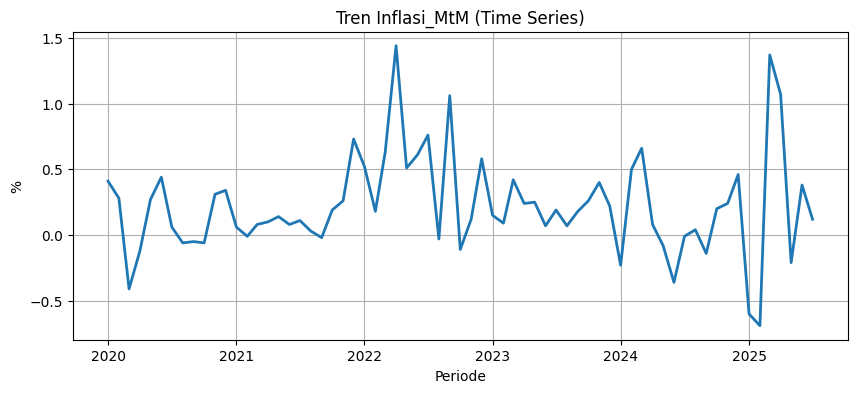

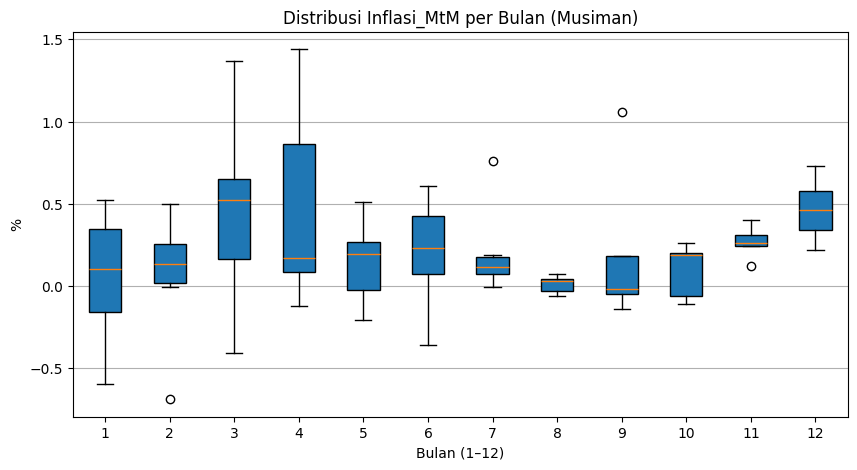

=== Uji ADF ===
Statistic: -2.0421 | p-value: 0.2684
  Critical 1%: -3.5405
  Critical 5%: -2.9094
  Critical 10%: -2.5923
=> Belum stasioner (gagal tolak H0) 



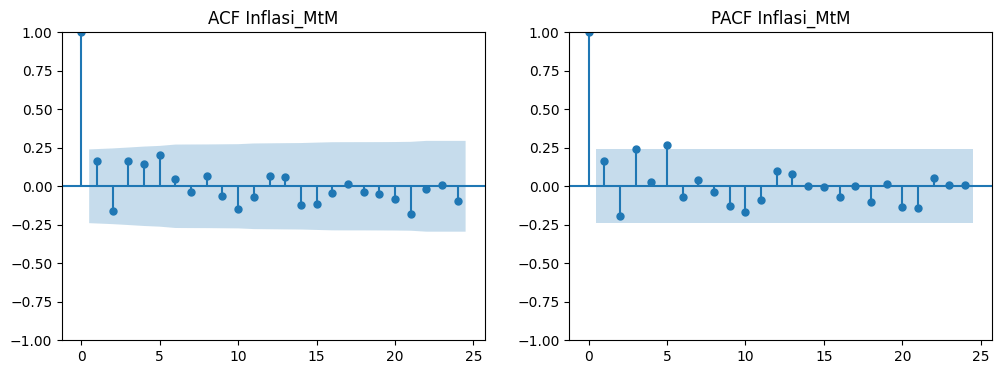

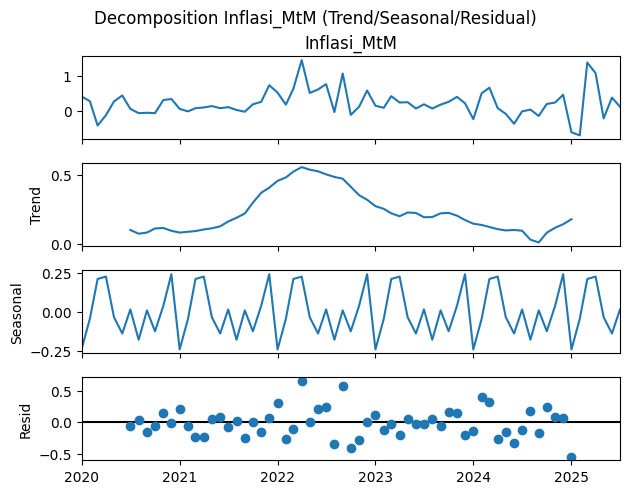

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose


# pastikan kita punya seri waktu datetime dari kolom 'Tanggal'
if "Tanggal" not in inflasi_dt.columns:
    raise KeyError("Kolom 'Tanggal' tidak ditemukan di inflasi_dt.")
t_idx = pd.to_datetime(inflasi_dt["Tanggal"], errors="coerce")

# opsional: jadikan index datetime (tidak wajib, tapi memudahkan plotting)
inflasi_dt = inflasi_dt.set_index(t_idx).sort_index()

# 1) Deteksi otomatis kolom target (prioritas MtM, fallback YoY)
cands_mtm = [c for c in inflasi_dt.columns if "inflasi" in c.lower() and ("mtm" in c.lower() or "month" in c.lower())]
if cands_mtm:
    TARGET_COL = cands_mtm[0]
else:
    cands_yoy = [c for c in inflasi_dt.columns if "inflasi" in c.lower() and ("yoy" in c.lower() or "year" in c.lower())]
    if not cands_yoy:
        raise KeyError("Tidak menemukan kolom target (MtM/YoY) di inflasi_dt.")
    TARGET_COL = cands_yoy[0]

print("✅ TARGET_COL:", TARGET_COL)

# ambil seri target sebagai float
y = pd.to_numeric(inflasi_dt[TARGET_COL], errors="coerce")

# 2) Statistik deskriptif
print("\n=== Statistik Deskriptif", TARGET_COL, "===")
print(y.describe(), "\n")
print(f"Rata-rata {TARGET_COL}: {y.mean():.3f}%")
print(f"Rentang {TARGET_COL}: {y.min():.3f}% s.d. {y.max():.3f}%\n")

# 3) Tren inflasi (time series)
plt.figure(figsize=(10,4))
plt.plot(y.index, y.values, color='tab:blue', linewidth=2)
plt.title(f"Tren {TARGET_COL} (Time Series)")
plt.xlabel("Periode"); plt.ylabel("%")
plt.grid(True); plt.show()

# 4) Musiman (boxplot per bulan) — ambil bulan dari kolom Tanggal
bulan_num = inflasi_dt.index.month
data_per_bulan = [y[bulan_num == m] for m in range(1,13)]

plt.figure(figsize=(10,5))
plt.boxplot(data_per_bulan, labels=[str(m) for m in range(1,13)], patch_artist=True)
plt.title(f"Distribusi {TARGET_COL} per Bulan (Musiman)")
plt.xlabel("Bulan (1–12)"); plt.ylabel("%")
plt.grid(True, axis='y'); plt.show()

# 5) Uji stasioneritas (ADF)
adf = adfuller(y.dropna())
print("=== Uji ADF ===")
print(f"Statistic: {adf[0]:.4f} | p-value: {adf[1]:.4f}")
for k,v in adf[4].items():
    print(f"  Critical {k}: {v:.4f}")
print("=>", "Stasioner (tolak H0)" if adf[1] < 0.05 else "Belum stasioner (gagal tolak H0)", "\n")

# 6) ACF & PACF (untuk bantu identifikasi p & q)
fig, ax = plt.subplots(1,2, figsize=(12,4))
plot_acf(y.dropna(), lags=24, ax=ax[0]); ax[0].set_title(f"ACF {TARGET_COL}")
plot_pacf(y.dropna(), lags=24, ax=ax[1]); ax[1].set_title(f"PACF {TARGET_COL}")
plt.show()

# 7) Decomposition (Trend/Seasonal/Residual) – additive period=12
#    (akan skip jika data terlalu pendek)
try:
    dec = seasonal_decompose(y, model='additive', period=12)
    dec.plot()
    plt.suptitle(f"Decomposition {TARGET_COL} (Trend/Seasonal/Residual)", y=1.02)
    plt.show()
except Exception as e:
    print("Decomposition di-skip:", e)


# Cell (EDA Visual) — eda_visualize_prices_inflation (visualisasi komoditas & inflasi)

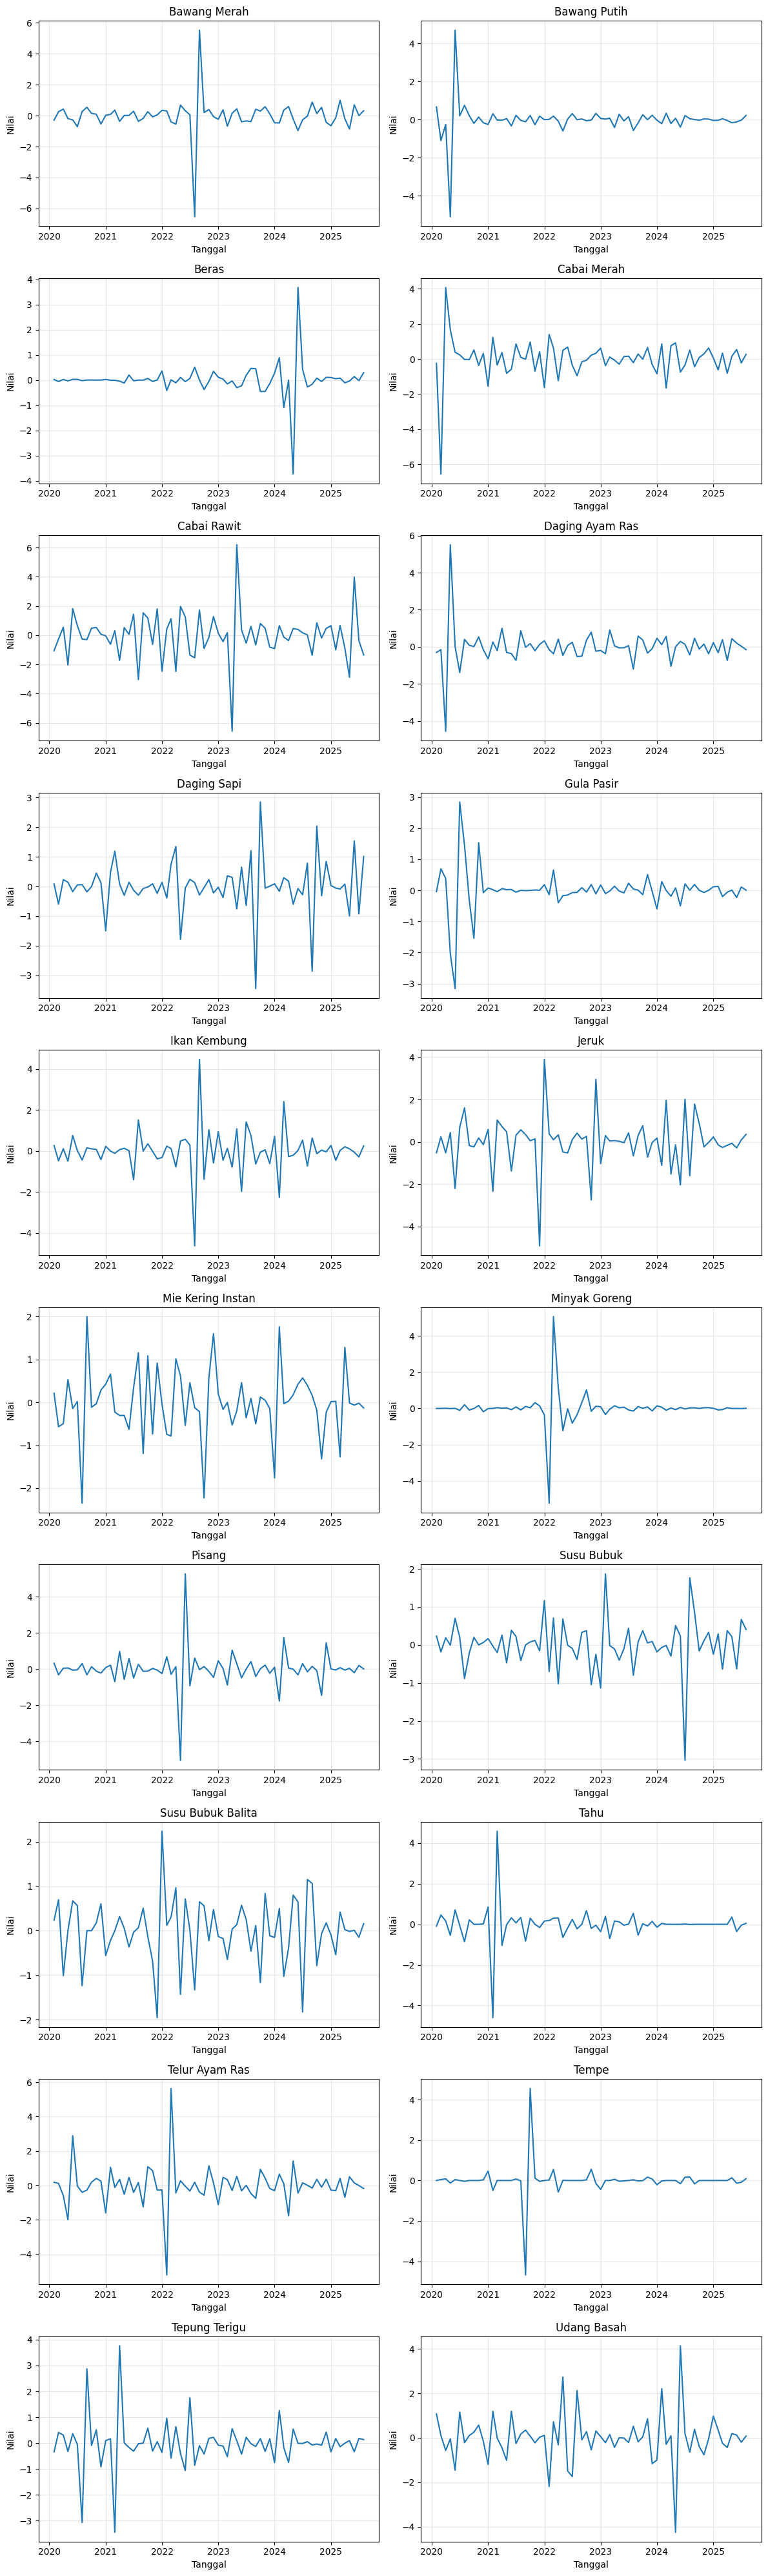

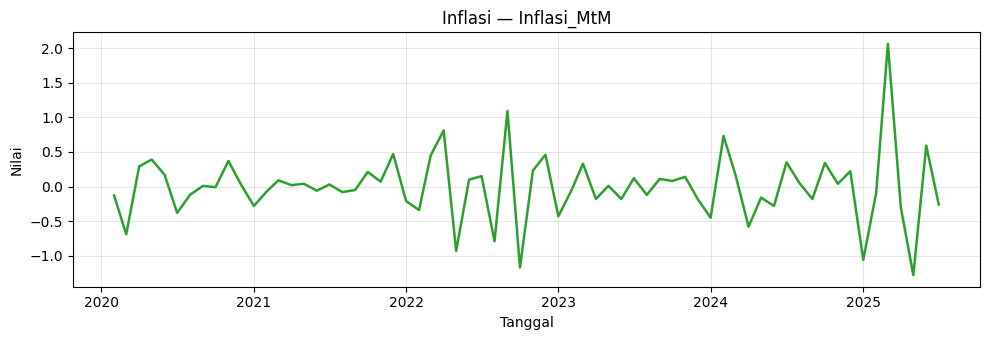

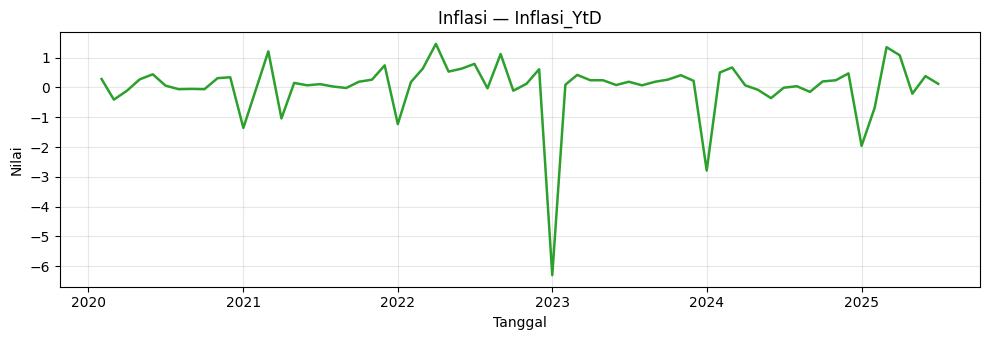

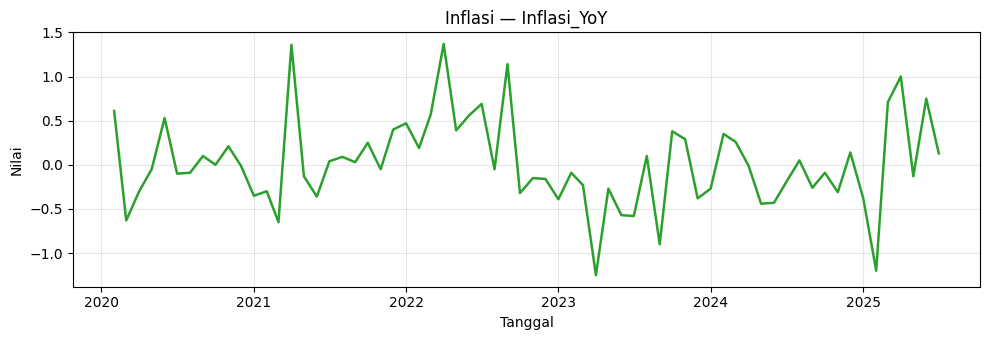

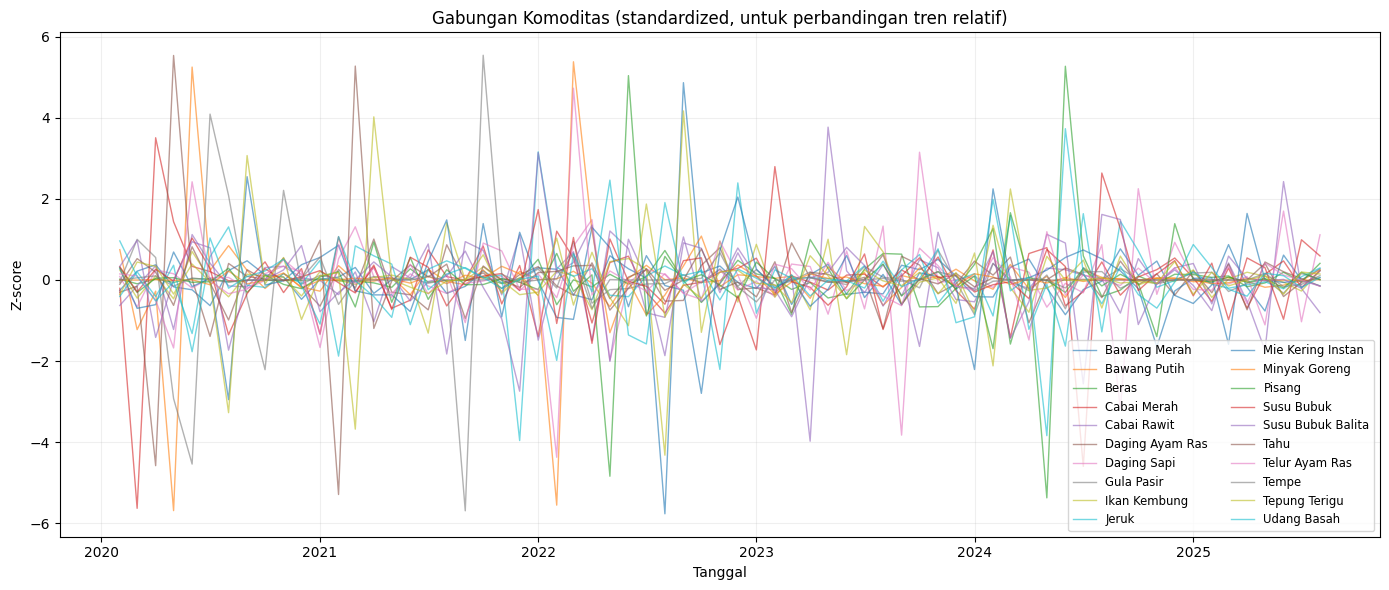

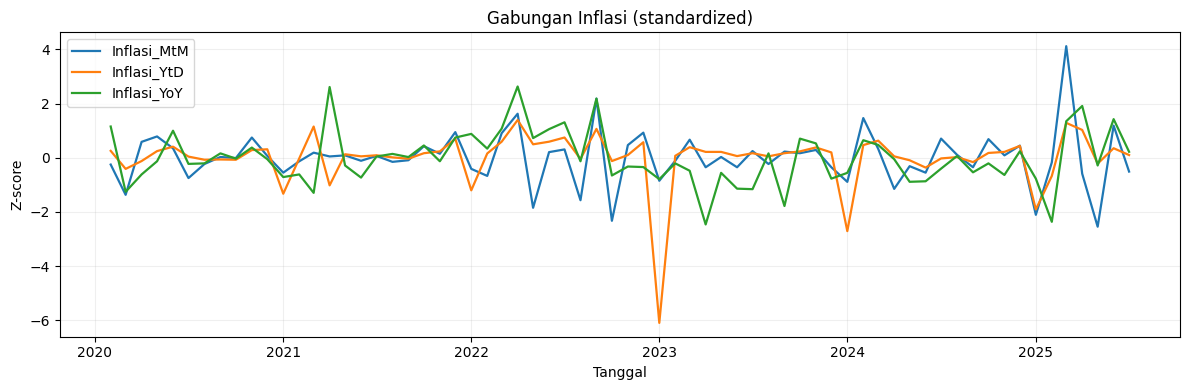

In [27]:
def eda_visualize_prices_inflation(series_map, inflasi_series, max_kom=20, cols=2):
    import math
    # 1) Individual komoditas (maks max_kom)f
    kom_list = list(series_map.keys())[:max_kom]
    n = len(kom_list)
    if n > 0:
        rows = math.ceil(n / cols)
        fig, axes = plt.subplots(rows, cols, figsize=(12, 4*rows))
        axes = axes.flatten() if hasattr(axes, "__len__") else [axes]
        for i, kom in enumerate(kom_list):
            s = series_map[kom].dropna()
            if s.empty:
                axes[i].text(0.5,0.5,"No data",ha='center')
                axes[i].set_title(kom); axes[i].grid(alpha=0.3); continue
            if USE_LOG_FOR_PRICE and np.nanmin(s.values) > 0:
                plot_s = np.exp(s)
            else:
                plot_s = s
            axes[i].plot(plot_s.index, plot_s.values, color='tab:blue', linewidth=1.5)
            axes[i].set_title(kom)
            axes[i].set_xlabel('Tanggal'); axes[i].set_ylabel('Nilai'); axes[i].grid(alpha=0.3)
        # matikan axis kosong
        for j in range(i+1, len(axes)):
            axes[j].axis('off')
        plt.tight_layout(); plt.show()
    else:
        print("Tidak ada komoditas untuk divisualisasikan.")

    # 2) Individual inflasi
    for name, s in inflasi_series.items():
        s = s.dropna()
        if s.empty:
            print(f"{name}: no data, skip")
            continue
        plt.figure(figsize=(10,3.5))
        plt.plot(s.index, s.values, color='tab:green', linewidth=1.8)
        plt.title(f'Inflasi — {name}')
        plt.xlabel('Tanggal'); plt.ylabel('Nilai'); plt.grid(alpha=0.3)
        plt.tight_layout(); plt.show()

    # 3) Gabungan semua komoditas (standardized overlay)
    if len(series_map) > 0:
        # gabungkan ke DataFrame (outer join), gunakan ffill untuk short gaps
        df = pd.DataFrame({k: v.reindex(pd.date_range(
            min([s.index.min() for s in series_map.values() if len(s)>0]),
            max([s.index.max() for s in series_map.values() if len(s)>0]),
            freq='MS')) for k,v in series_map.items()})
        df = df.apply(lambda col: col.ffill())  # isi celah kecil agar standardisasi stabil
        # inverse log jika perlu untuk interpretasi (lakukan sebelum standardisasi)
        if USE_LOG_FOR_PRICE:
            # hanya invert series yang benar-benar dilog
            for k in df.columns:
                s = series_map.get(k, pd.Series(dtype=float)).dropna()
                if len(s)>0 and np.nanmin(s.values) > 0:
                    # reindex original and exp
                    df[k] = np.exp(df[k])
        # standardize per kolom
        df_z = (df - df.mean()) / df.std()
        plt.figure(figsize=(14,6))
        for col in df_z.columns:
            plt.plot(df_z.index, df_z[col], label=col, alpha=0.6, linewidth=1)
        plt.title('Gabungan Komoditas (standardized, untuk perbandingan tren relatif)')
        # tampilkan legenda ringkas jika tidak terlalu banyak kolom
        if len(df_z.columns) <= 20:
            plt.legend(ncol=2, fontsize='small')
        plt.xlabel('Tanggal'); plt.ylabel('Z-score'); plt.grid(alpha=0.2)
        plt.tight_layout(); plt.show()
    else:
        print("Tidak ada komoditas untuk grafik gabungan.")

    # 4) Gabungan inflasi (standardized)
    if len(inflasi_series) > 0:
        df_inf = pd.DataFrame({k: v for k,v in inflasi_series.items()})
        df_inf = df_inf.apply(lambda col: col.ffill())
        df_inf_z = (df_inf - df_inf.mean()) / df_inf.std()
        plt.figure(figsize=(12,4))
        for col in df_inf_z.columns:
            plt.plot(df_inf_z.index, df_inf_z[col], label=col, linewidth=1.6)
        plt.title('Gabungan Inflasi (standardized)')
        plt.xlabel('Tanggal'); plt.ylabel('Z-score'); plt.grid(alpha=0.2)
        plt.legend()
        plt.tight_layout(); plt.show()
    else:
        print("Tidak ada seri inflasi untuk divisualisasikan.")

# jalankan EDA baru (masukkan setelah Cell 8)
eda_visualize_prices_inflation(series_map, inflasi_series, max_kom=20, cols=2)

# Cell 9 — Evaluasi (holdout 6 bulan) dengan SARIMAX + exog (domain)

Tujuan: ukur baseline akurasi dengan memasukkan eksogen sesuai mapping; tanpa kebocoran data (exog test disusun hanya dari periode test).

In [28]:
# Cell BARU — Forecasting Utama (SEBELUM EVALUASI)
# ====== FORECASTING UTAMA ======

def run_forecasting_pipeline(series_map, horizon=6, use_grid_search=False, exog_policy='domain'):
    """Jalankan pipeline forecasting untuk semua komoditas"""
    
    forecasts = {}
    model_results = {}
    
    print("=== MEMULAI FORECASTING UTAMA ===")
    print(f"Horizon: {horizon} bulan | Grid Search: {use_grid_search} | Exog Policy: {exog_policy}\n")
    
    for i, (komoditas, series) in enumerate(series_map.items()):
        print(f"[{i+1}/{len(series_map)}] Forecasting: {komoditas}")
        
        try:
            # Bangun matrix eksogen
            exog_matrix, exog_used, scaler = build_exog_matrix(
                komoditas, series_map, series.index, policy=exog_policy
            )
            
            # Pilih order model
            if use_grid_search:
                order, seasonal_order = select_order_aic(series)
                print(f"   Grid Search -> Order: {order}, Seasonal: {seasonal_order}")
            else:
                order, seasonal_order = DEFAULT_ORDER, DEFAULT_SEASONAL_ORDER
                print(f"   Default -> Order: {order}, Seasonal: {seasonal_order}")
            
            # Fit model
            if exog_matrix is not None:
                print(f"   Dengan eksogen: {exog_used}")
                model = SARIMAX(series, order=order, seasonal_order=seasonal_order,
                              exog=exog_matrix, enforce_stationarity=False,
                              enforce_invertibility=False)
            else:
                print(f"   Tanpa eksogen")
                model = SARIMAX(series, order=order, seasonal_order=seasonal_order,
                              enforce_stationarity=False, enforce_invertibility=False)
            
            fitted_model = model.fit(disp=False)
            
            # Forecast masa depan
            if exog_matrix is not None:
                # Forecast eksogen untuk periode future
                exog_future_list = []
                for exog_col in exog_used:
                    if exog_col in series_map:
                        exog_series = series_map[exog_col]
                    elif exog_col in inflasi_series:
                        exog_series = inflasi_series[exog_col]
                    else:
                        continue
                    
                    # Forecast univariat untuk setiap eksogen
                    exog_forecast = forecast_univariate(
                        exog_series, horizon=horizon,
                        use_grid=False, default_order=DEFAULT_ORDER,
                        default_seasonal=DEFAULT_SEASONAL_ORDER
                    )
                    exog_future_list.append(exog_forecast)
                
                # Gabungkan forecast eksogen
                if exog_future_list:
                    exog_future = pd.concat(exog_future_list, axis=1)
                    exog_future.columns = exog_used
                    # Apply scaler yang sama
                    exog_future_scaled = apply_scaler_exog(exog_future, scaler)
                else:
                    exog_future_scaled = None
            else:
                exog_future_scaled = None
            
            # Buat forecast
            if exog_future_scaled is not None:
                forecast_result = fitted_model.get_forecast(
                    steps=horizon, exog=exog_future_scaled
                )
            else:
                forecast_result = fitted_model.get_forecast(steps=horizon)
            
            forecast_mean = forecast_result.predicted_mean
            forecast_conf_int = forecast_result.conf_int()
            
            # Simpan hasil
            forecasts[komoditas] = {
                'actual': series,
                'forecast': forecast_mean,
                'conf_int': forecast_conf_int,
                'model': fitted_model,
                'exog_used': exog_used
            }
            
            model_results[komoditas] = {
                'order': order,
                'seasonal_order': seasonal_order,
                'exog_used': exog_used,
                'aic': fitted_model.aic,
                'bic': fitted_model.bic
            }
            
            print(f"   ✅ Forecast berhasil | AIC: {fitted_model.aic:.2f}")
            
        except Exception as e:
            print(f"   ❌ Forecast gagal: {str(e)}")
            # Fallback: forecast sederhana tanpa eksogen
            try:
                simple_forecast = forecast_univariate(
                    series, horizon=horizon, use_grid=False,
                    default_order=DEFAULT_ORDER, default_seasonal=DEFAULT_SEASONAL_ORDER
                )
                
                forecasts[komoditas] = {
                    'actual': series,
                    'forecast': simple_forecast,
                    'conf_int': None,
                    'model': None,
                    'exog_used': []
                }
                
                model_results[komoditas] = {
                    'order': DEFAULT_ORDER,
                    'seasonal_order': DEFAULT_SEASONAL_ORDER,
                    'exog_used': [],
                    'aic': None,
                    'bic': None
                }
                
                print(f"   ⚠️  Fallback forecast berhasil")
                
            except Exception as e2:
                print(f"   💥 Fallback juga gagal: {str(e2)}")
    
    return forecasts, model_results

# JALANKAN FORECASTING UTAMA DI SINI
print("=== MENJALANKAN FORECASTING UTAMA ===")
forecasts, model_results = run_forecasting_pipeline(
    series_map, 
    horizon=FORECAST_HORIZON,
    use_grid_search=USE_GRID_SEARCH,
    exog_policy=EXOG_POLICY
)

print(f"\n✅ Forecasting komoditas selesai: {len(forecasts)} komoditas berhasil")

=== MENJALANKAN FORECASTING UTAMA ===
=== MEMULAI FORECASTING UTAMA ===
Horizon: 6 bulan | Grid Search: False | Exog Policy: domain

[1/20] Forecasting: Bawang Merah
   Default -> Order: (1, 1, 1), Seasonal: (1, 1, 1, 12)
   Dengan eksogen: ['Bawang Putih', 'Cabai Merah', 'Cabai Rawit', 'Minyak Goreng']
   ✅ Forecast berhasil | AIC: 155.19
[2/20] Forecasting: Bawang Putih
   Default -> Order: (1, 1, 1), Seasonal: (1, 1, 1, 12)
   Dengan eksogen: ['Bawang Merah', 'Cabai Rawit', 'Cabai Merah', 'Tempe']
   ✅ Forecast berhasil | AIC: 13.30
[3/20] Forecasting: Beras
   Default -> Order: (1, 1, 1), Seasonal: (1, 1, 1, 12)
   Dengan eksogen: ['Mie Kering Instan', 'Tepung Terigu', 'Gula Pasir', 'Minyak Goreng']
   ✅ Forecast berhasil | AIC: 116.48
[4/20] Forecasting: Cabai Merah
   Default -> Order: (1, 1, 1), Seasonal: (1, 1, 1, 12)
   Dengan eksogen: ['Cabai Rawit', 'Bawang Merah', 'Bawang Putih']
   ✅ Forecast berhasil | AIC: 101.76
[5/20] Forecasting: Cabai Rawit
   Default -> Order: (1, 1

=== MENJALANKAN EVALUASI TRAIN-TEST ===
=== MEMULAI EVALUASI KOMPREHENSIF ===
Test size: 0.2, Horizon: 6 bulan

[1/20] Evaluating: Bawang Merah
   ✅ Evaluasi berhasil - MAPE: 10.81%
[2/20] Evaluating: Bawang Putih
   ✅ Evaluasi berhasil - MAPE: 22.10%
[3/20] Evaluating: Beras
   ✅ Evaluasi berhasil - MAPE: 16.05%
[4/20] Evaluating: Cabai Merah
   ✅ Evaluasi berhasil - MAPE: 1.72%
[5/20] Evaluating: Cabai Rawit
   ✅ Evaluasi berhasil - MAPE: 11.36%
[6/20] Evaluating: Daging Ayam Ras
   ✅ Evaluasi berhasil - MAPE: 3.58%
[7/20] Evaluating: Daging Sapi
   ✅ Evaluasi berhasil - MAPE: 1.03%
[8/20] Evaluating: Gula Pasir
   ✅ Evaluasi berhasil - MAPE: 60.19%
[9/20] Evaluating: Ikan Kembung
   ✅ Evaluasi berhasil - MAPE: 9.13%
[10/20] Evaluating: Jeruk
   ✅ Evaluasi berhasil - MAPE: 12.41%
[11/20] Evaluating: Mie Kering Instan
   ✅ Evaluasi berhasil - MAPE: 4.78%
[12/20] Evaluating: Minyak Goreng
   ✅ Evaluasi berhasil - MAPE: 1943.05%
[13/20] Evaluating: Pisang
   ✅ Evaluasi berhasil - MAPE: 

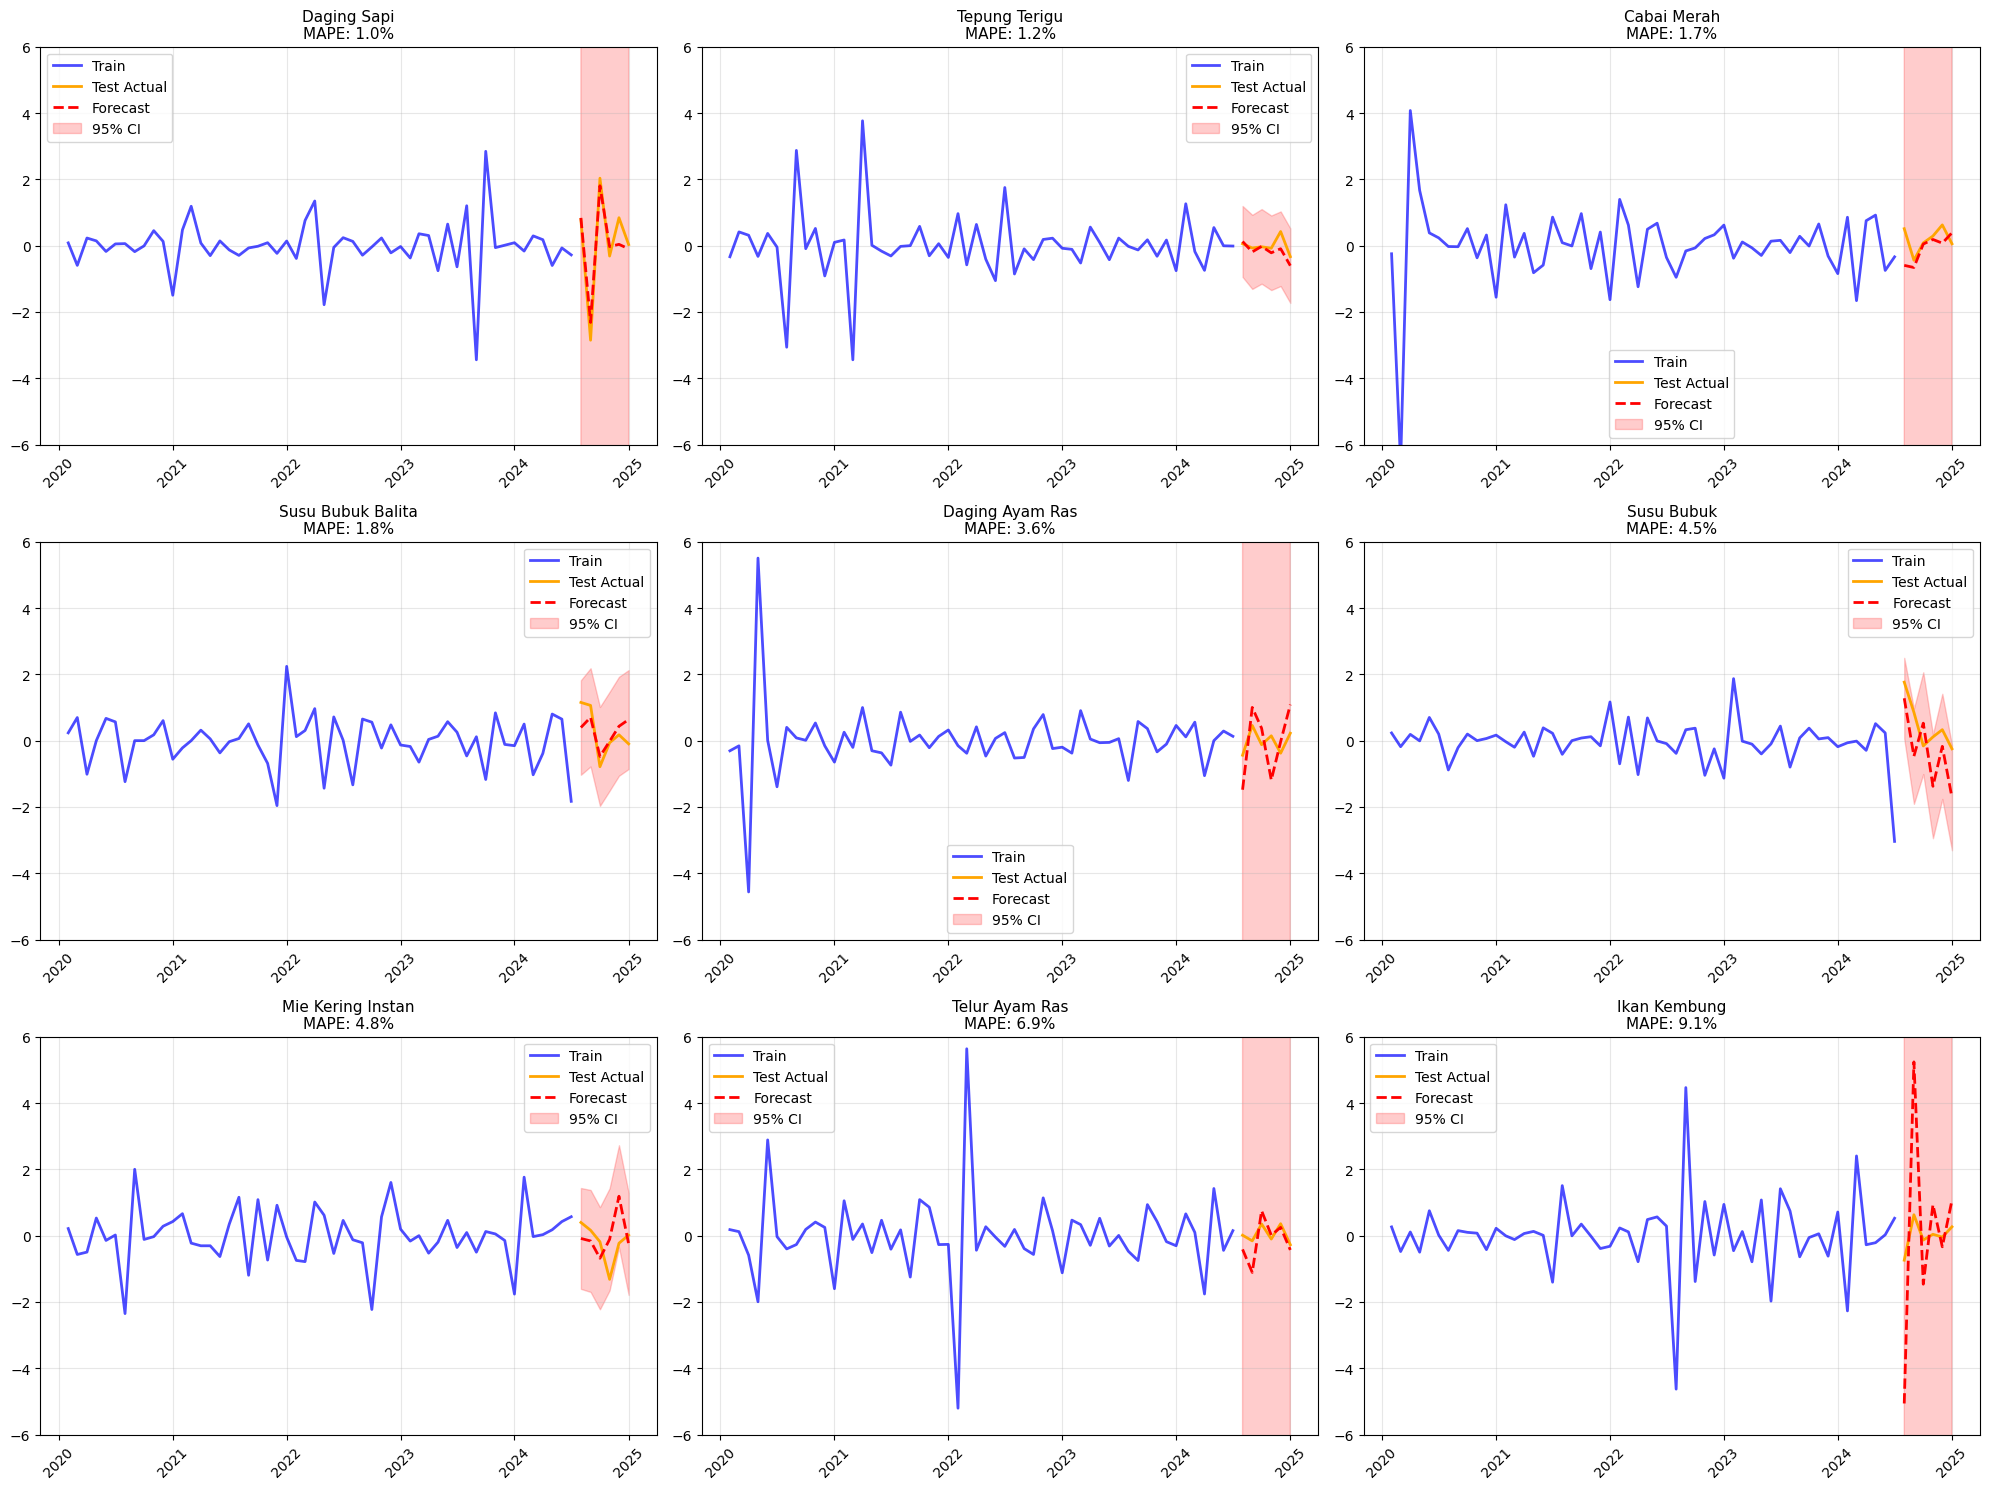


=== EXPORTING EVALUATION RESULTS ===
✅ Hasil evaluasi disimpan sebagai 'evaluation_results.csv'
✅ Summary statistics disimpan sebagai 'evaluation_summary_stats.csv'

=== MODEL TERBAIK (Berdasarkan MAPE - lebih kecil lebih baik) ===
            Komoditas   MAPE
6         Daging Sapi 1.0334
18      Tepung Terigu 1.1685
3         Cabai Merah 1.7195
14  Susu Bubuk Balita 1.8412
5     Daging Ayam Ras 3.5830

=== MODEL TERBURUK (Berdasarkan MAPE - lebih besar lebih buruk) ===
        Komoditas       MAPE
11  Minyak Goreng 1,943.0470
7      Gula Pasir    60.1868
17          Tempe    46.4887
15           Tahu    40.9395
19    Udang Basah    36.3716


In [36]:
# Cell 2 — Train-Test Split & Evaluation
# ====== TRAIN-TEST EVALUATION COMPREHENSIVE ======

import matplotlib.pyplot as plt


def train_test_split_time_series(series, test_size=0.2):
    """Split time series data into train and test sets"""
    n = len(series)
    test_length = int(n * test_size)
    train_length = n - test_length
    
    train = series.iloc[:train_length]
    test = series.iloc[train_length:]
    
    return train, test

def evaluate_forecast_model(series, horizon=6, order=(1,1,1), seasonal_order=(1,1,1,12), 
                          exog_data=None, test_size=0.2):
    """Evaluasi model forecasting dengan train-test split"""
    
    # Split data
    train, test = train_test_split_time_series(series, test_size=test_size)
    
    if len(train) < 12 or len(test) < horizon:
        return None, "Data terlalu pendek untuk evaluasi"
    
    try:
        # Split exog data jika ada
        if exog_data is not None:
            exog_train = exog_data.iloc[:len(train)]
            exog_test = exog_data.iloc[len(train):len(train) + horizon]
        else:
            exog_train = exog_test = None
        
        # Fit model
        model = SARIMAX(train, order=order, seasonal_order=seasonal_order,
                       exog=exog_train, enforce_stationarity=False,
                       enforce_invertibility=False)
        fitted_model = model.fit(disp=False)
        
        # Forecast untuk horizon yang sama dengan test set
        forecast_result = fitted_model.get_forecast(steps=horizon, exog=exog_test)
        forecast_mean = forecast_result.predicted_mean
        forecast_conf_int = forecast_result.conf_int()
        
        # Ambil bagian test yang sesuai dengan forecast horizon
        test_actual = test.iloc[:horizon]
        
        # Hitung metrics - HANYA MAPE
        metrics = calculate_forecast_metrics(test_actual.values, forecast_mean.values)
        metrics['aic'] = fitted_model.aic
        metrics['bic'] = fitted_model.bic
        
        return {
            'train': train,
            'test': test_actual,
            'forecast': forecast_mean,
            'conf_int': forecast_conf_int,
            'model': fitted_model,
            'metrics': metrics
        }, None
        
    except Exception as e:
        return None, str(e)

def calculate_forecast_metrics(actual, forecast):
    """Hitung metrics evaluasi forecast - HANYA MAPE"""
    
    actual = np.array(actual)
    forecast = np.array(forecast)
    
    # HANYA 1 METRIC YANG DIHITUNG: MAPE
    mape_val = mape(actual, forecast)
    
    return {
        'MAPE': mape_val
    }

def run_comprehensive_evaluation(forecasts_dict, model_results, test_size=0.2, horizon=6):
    """Jalankan evaluasi komprehensif untuk semua model"""
    
    evaluation_results = {}
    summary_metrics = []
    
    print("=== MEMULAI EVALUASI KOMPREHENSIF ===")
    print(f"Test size: {test_size}, Horizon: {horizon} bulan\n")
    
    for i, (komoditas, forecast_data) in enumerate(forecasts_dict.items()):
        print(f"[{i+1}/{len(forecasts_dict)}] Evaluating: {komoditas}")
        
        series = forecast_data['actual']
        
        # Dapatkan parameter model yang digunakan
        if komoditas in model_results:
            model_info = model_results[komoditas]
            order = model_info['order']
            seasonal_order = model_info['seasonal_order']
            exog_used = model_info['exog_used']
        else:
            # Default parameters
            order = DEFAULT_ORDER
            seasonal_order = DEFAULT_SEASONAL_ORDER
            exog_used = []
        
        # Bangun exog data jika ada
        exog_data = None
        if exog_used:
            try:
                exog_data = build_exog_matrix_for_eval(komoditas, exog_used, series.index)
            except:
                exog_data = None
        
        # Evaluasi model
        result, error = evaluate_forecast_model(
            series, horizon=horizon, order=order, seasonal_order=seasonal_order,
            exog_data=exog_data, test_size=test_size
        )
        
        if result:
            evaluation_results[komoditas] = result
            metrics = result['metrics']
            
            # Tambah ke summary - HANYA MAPE
            metrics_summary = {
                'Komoditas': komoditas,
                'Order': order,
                'Seasonal_Order': seasonal_order,
                'Exog_Used': len(exog_used) if exog_used else 0,
                'MAPE': metrics['MAPE']
            }
            summary_metrics.append(metrics_summary)
            
            print(f"   ✅ Evaluasi berhasil - MAPE: {metrics['MAPE']:.2f}%")
        else:
            print(f"   ❌ Evaluasi gagal: {error}")
    
    # Buat summary dataframe
    if summary_metrics:
        summary_df = pd.DataFrame(summary_metrics)
        
        # Hitung statistics overall - HANYA untuk MAPE
        overall_stats = {
            'Metric': ['MAPE'],
            'Mean': [summary_df['MAPE'].mean()],
            'Std': [summary_df['MAPE'].std()],
            'Min': [summary_df['MAPE'].min()],
            'Max': [summary_df['MAPE'].max()]
        }
        
        overall_stats_df = pd.DataFrame(overall_stats)
        
        return evaluation_results, summary_df, overall_stats_df
    else:
        return evaluation_results, None, None

def build_exog_matrix_for_eval(target_komoditas, exog_list, index):
    """Bangun matrix eksogen untuk evaluasi"""
    if not exog_list:
        return None
    
    X = pd.DataFrame(index=index)
    for col in exog_list:
        if col in series_map:
            s = series_map[col].reindex(index)
            s = s.ffill().bfill()
            X[col] = s.values
        elif col in inflasi_series:
            s = inflasi_series[col].reindex(index)
            s = s.ffill().bfill()
            X[col] = s.values
    
    # Standardisasi
    if len(X.columns) > 0:
        means = X.mean(axis=0)
        stds = X.std(axis=0).replace(0, 1.0)
        Xz = (X - means) / stds
        return Xz.fillna(0.0)
    else:
        return None

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
# Pastikan import library lain yang dibutuhkan sudah ada (SARIMAX, dsb)

# ... (fungsi train_test_split_time_series dan evaluate_forecast_model biarkan seperti semula) ...

def plot_evaluation_results(evaluation_results, top_n=9):
    """Plot hasil evaluasi untuk model terbaik"""
    
    if not evaluation_results:
        print("❌ Tidak ada hasil evaluasi untuk diplot")
        return
    
    # Pilih model terbaik berdasarkan MAPE (lebih kecil lebih baik)
    best_models = sorted(
        [(kom, result['metrics']['MAPE']) for kom, result in evaluation_results.items()],
        key=lambda x: x[1]
    )[:top_n]
    
    n_plots = min(len(best_models), top_n)
    n_cols = 3
    n_rows = (n_plots + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
    if n_plots == 1:
        axes = np.array([axes])
    axes = axes.flatten()
    
    for idx, (komoditas, mape_val) in enumerate(best_models):
        if idx >= len(axes):
            break
            
        result = evaluation_results[komoditas]
        ax = axes[idx]
        
        # === BATASI SKALA Y DI SINI ===
        # Ini akan memaksa grafik fokus pada rentang -5 sampai 5
        # sehingga garis tidak terlihat datar (gepeng) karena outlier
        ax.set_ylim(-6, 6) 
        # ==============================

        # Plot data
        train = result['train']
        test = result['test']
        forecast = result['forecast']
        conf_int = result['conf_int']
        
        # Plot train
        ax.plot(train.index, train.values, 'b-', label='Train', linewidth=2, alpha=0.7)
        
        # Plot test actual - warna orange untuk kontras
        ax.plot(test.index, test.values, 'orange', label='Test Actual', linewidth=2)
        
        # Plot forecast
        ax.plot(forecast.index, forecast.values, 'r--', label='Forecast', linewidth=2)
        
        # Plot confidence interval (Opsional: bisa dikomen jika masih mengganggu)
        ax.fill_between(forecast.index, 
                        conf_int.iloc[:, 0], 
                        conf_int.iloc[:, 1], 
                        alpha=0.2, color='red', label='95% CI')
        
        metrics = result['metrics']
        title = f'{komoditas}\nMAPE: {metrics["MAPE"]:.1f}%'
        ax.set_title(title, fontsize=11)
        ax.legend()
        ax.grid(True, alpha=0.3)
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
    
    # Hide unused subplots
    for idx in range(len(best_models), len(axes)):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    plt.savefig('evaluation_results.png', dpi=300, bbox_inches='tight')
    plt.show()

def export_evaluation_results(evaluation_results, summary_df, overall_stats_df, filename='evaluation_results.csv'):
    """Export hasil evaluasi ke CSV"""
    
    if not evaluation_results:
        print("❌ Tidak ada hasil evaluasi untuk diexport")
        return None
    
    # Export detailed results
    detailed_results = []
    
    for komoditas, result in evaluation_results.items():
        metrics = result['metrics']
        
        # Data point per point
        for i, (date, actual, forecast) in enumerate(zip(
            result['test'].index, 
            result['test'].values, 
            result['forecast'].values
        )):
            detailed_results.append({
                'Komoditas': komoditas,
                'Tanggal': date,
                'Actual': actual,
                'Forecast': forecast,
                'Error': forecast - actual,
                'Absolute_Error': abs(forecast - actual),
                'Percentage_Error': ((forecast - actual) / actual * 100) if actual != 0 else np.nan,
                'Horizon': i + 1
            })
    
    detailed_df = pd.DataFrame(detailed_results)
    
    # Gabungkan dengan summary metrics - HANYA MAPE
    if summary_df is not None:
        final_df = pd.merge(detailed_df, summary_df[['Komoditas', 'MAPE']], 
                           on='Komoditas', how='left')
    else:
        final_df = detailed_df
    
    # Simpan ke CSV
    if SAVE_CSV:
        final_df.to_csv(filename, index=False, float_format='%.6f')
        print(f"✅ Hasil evaluasi disimpan sebagai '{filename}'")
        
        # Simpan summary statistics
        if overall_stats_df is not None:
            overall_stats_df.to_csv('evaluation_summary_stats.csv', index=False, float_format='%.6f')
            print("✅ Summary statistics disimpan sebagai 'evaluation_summary_stats.csv'")
    
    return final_df, overall_stats_df

# Define global variables
DEFAULT_ORDER = (1,1,1)
DEFAULT_SEASONAL_ORDER = (1,1,1,12)
TEST_SIZE = 0.2
FORECAST_HORIZON = 6
SAVE_CSV = True

# Jalankan evaluasi komprehensif
print("=== MENJALANKAN EVALUASI TRAIN-TEST ===")
eval_results, summary_df, overall_stats_df = run_comprehensive_evaluation(
    forecasts, model_results, test_size=TEST_SIZE, horizon=FORECAST_HORIZON
)

# Tampilkan hasil
if summary_df is not None:
    print("\n=== HASIL EVALUASI DETAIL ===")
    print(summary_df.round(4))
    
    print("\n=== STATISTIK OVERALL ===")
    print(overall_stats_df.round(4))
    
    # Plot hasil evaluasi
    print("\n=== GENERATING EVALUATION PLOTS ===")
    plot_evaluation_results(eval_results)
    
    # Export hasil evaluasi
    print("\n=== EXPORTING EVALUATION RESULTS ===")
    eval_csv, stats_csv = export_evaluation_results(eval_results, summary_df, overall_stats_df)
    
    # Tampilkan model terbaik dan terburuk - BERDASARKAN MAPE
    if summary_df is not None:
        print("\n=== MODEL TERBAIK (Berdasarkan MAPE - lebih kecil lebih baik) ===")
        best_models_mape = summary_df.nsmallest(5, 'MAPE')[['Komoditas', 'MAPE']]
        print(best_models_mape.round(4))

        print("\n=== MODEL TERBURUK (Berdasarkan MAPE - lebih besar lebih buruk) ===")
        worst_models_mape = summary_df.nlargest(5, 'MAPE')[['Komoditas', 'MAPE']]
        print(worst_models_mape.round(4))
else:
    print("❌ Evaluasi tidak menghasilkan hasil")

In [30]:
# Cell BARU — Forecasting Inflasi (FIXED)
# ====== INFLATION FORECASTING ======

def run_inflation_forecasting(inflasi_series, horizon=6, use_grid_search=False):
    """Jalankan forecasting untuk series inflasi"""
    
    inflation_forecasts = {}
    inflation_model_results = {}
    
    print("=== MEMULAI FORECASTING INFLASI ===")
    
    for i, (inflasi_type, series) in enumerate(inflasi_series.items()):
        print(f"[{i+1}/{len(inflasi_series)}] Forecasting: {inflasi_type}")
        
        try:
            # Pilih order model
            if use_grid_search:
                order, seasonal_order = select_order_aic(series)
                print(f"   Grid Search -> Order: {order}, Seasonal: {seasonal_order}")
            else:
                order, seasonal_order = DEFAULT_ORDER, DEFAULT_SEASONAL_ORDER
                print(f"   Default -> Order: {order}, Seasonal: {seasonal_order}")
            
            # Fit model (tanpa eksogen untuk inflasi)
            model = SARIMAX(series, order=order, seasonal_order=seasonal_order,
                          enforce_stationarity=False, enforce_invertibility=False)
            fitted_model = model.fit(disp=False)
            
            # Buat forecast
            forecast_result = fitted_model.get_forecast(steps=horizon)
            forecast_mean = forecast_result.predicted_mean
            forecast_conf_int = forecast_result.conf_int()
            
            # Simpan hasil
            inflation_forecasts[inflasi_type] = {
                'actual': series,
                'forecast': forecast_mean,
                'conf_int': forecast_conf_int,
                'model': fitted_model
            }
            
            inflation_model_results[inflasi_type] = {
                'order': order,
                'seasonal_order': seasonal_order,
                'aic': fitted_model.aic,
                'bic': fitted_model.bic
            }
            
            print(f"   ✅ Forecast berhasil | AIC: {fitted_model.aic:.2f}")
            
        except Exception as e:
            print(f"   ❌ Forecast gagal: {str(e)}")
            # Fallback: forecast sederhana
            try:
                simple_forecast = forecast_univariate(
                    series, horizon=horizon, use_grid=False,
                    default_order=DEFAULT_ORDER, default_seasonal=DEFAULT_SEASONAL_ORDER
                )
                
                inflation_forecasts[inflasi_type] = {
                    'actual': series,
                    'forecast': simple_forecast,
                    'conf_int': None,
                    'model': None
                }
                
                inflation_model_results[inflasi_type] = {
                    'order': DEFAULT_ORDER,
                    'seasonal_order': DEFAULT_SEASONAL_ORDER,
                    'aic': None,
                    'bic': None
                }
                
                print(f"   ⚠️  Fallback forecast berhasil")
                
            except Exception as e2:
                print(f"   💥 Fallback juga gagal: {str(e2)}")
    
    return inflation_forecasts, inflation_model_results

In [31]:
def plot_forecast_results(forecasts_dict, inflation_forecasts_dict=None, save_plots=SAVE_PLOTS):
    """Plot hasil forecast untuk komoditas dan inflasi"""
    
    if not forecasts_dict and not inflation_forecasts_dict:
        print("❌ Tidak ada data forecast untuk diplot")
        return
    
    # Plot komoditas
    if forecasts_dict:
        n_plots = len(forecasts_dict)
        n_cols = 3
        n_rows = max(1, (n_plots + n_cols - 1) // n_cols)
        
        print(f"Generating {n_plots} commodity plot(s) in {n_rows}x{n_cols} grid...")
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
        
        if n_plots == 1:
            axes = np.array([axes])
        
        axes = axes.flatten()
        
        for idx, (komoditas, data) in enumerate(forecasts_dict.items()):
            if idx >= len(axes):
                break
                
            ax = axes[idx]
            actual = data['actual']
            forecast = data['forecast']
            conf_int = data['conf_int']
            
            # Plot actual data
            ax.plot(actual.index, actual.values, 'b-', label='Actual', linewidth=2)
            
            # Plot forecast
            ax.plot(forecast.index, forecast.values, 'r--', label='Forecast', linewidth=2)
            
            # Plot confidence interval
            if conf_int is not None:
                ax.fill_between(forecast.index, 
                               conf_int.iloc[:, 0], 
                               conf_int.iloc[:, 1], 
                               alpha=0.2, color='red', label='95% CI')
            
            ax.set_title(f'Komoditas: {komoditas}\nForecast {FORECAST_HORIZON} Bulan', fontsize=12)
            ax.legend()
            ax.grid(True, alpha=0.3)
            plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
        
        # Hide unused subplots
        for idx in range(len(forecasts_dict), len(axes)):
            axes[idx].set_visible(False)
        
        plt.tight_layout()
        
        if save_plots:
            plt.savefig('forecast_commodities.png', dpi=300, bbox_inches='tight')
            print("✅ Plot komoditas disimpan sebagai 'forecast_commodities.png'")
        
        plt.show()
    
    # Plot inflasi
    if inflation_forecasts_dict:
        n_plots = len(inflation_forecasts_dict)
        n_cols = min(3, n_plots)
        n_rows = max(1, (n_plots + n_cols - 1) // n_cols)
        
        print(f"Generating {n_plots} inflation plot(s)...")
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
        
        if n_plots == 1:
            axes = np.array([axes])
        
        axes = axes.flatten()
        
        for idx, (inflasi_type, data) in enumerate(inflation_forecasts_dict.items()):
            if idx >= len(axes):
                break
                
            ax = axes[idx]
            actual = data['actual']
            forecast = data['forecast']
            conf_int = data['conf_int']
            
            # Plot actual data
            ax.plot(actual.index, actual.values, 'g-', label='Actual', linewidth=2)
            
            # Plot forecast
            ax.plot(forecast.index, forecast.values, 'orange', label='Forecast', linewidth=2)
            
            # Plot confidence interval
            if conf_int is not None:
                ax.fill_between(forecast.index, 
                               conf_int.iloc[:, 0], 
                               conf_int.iloc[:, 1], 
                               alpha=0.2, color='orange', label='95% CI')
            
            ax.set_title(f'Inflasi: {inflasi_type}\nForecast {FORECAST_HORIZON} Bulan', fontsize=12)
            ax.legend()
            ax.grid(True, alpha=0.3)
            plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
        
        # Hide unused subplots
        for idx in range(len(inflation_forecasts_dict), len(axes)):
            axes[idx].set_visible(False)
        
        plt.tight_layout()
        
        if save_plots:
            plt.savefig('forecast_inflation.png', dpi=300, bbox_inches='tight')
            print("✅ Plot inflasi disimpan sebagai 'forecast_inflation.png'")
        
        plt.show()

def export_to_csv(forecasts_dict, inflation_forecasts_dict=None, filename='forecast_results.csv'):
    """Export hasil forecast ke CSV - termasuk inflasi"""
    
    if not forecasts_dict and not inflation_forecasts_dict:
        print("❌ Tidak ada data forecast untuk diexport")
        return None
    
    all_forecasts = []
    
    # Export komoditas
    if forecasts_dict:
        for komoditas, data in forecasts_dict.items():
            forecast_df = data['forecast'].reset_index()
            forecast_df.columns = ['Tanggal', 'Forecast']
            forecast_df['Jenis'] = 'Komoditas'
            forecast_df['Nama'] = komoditas
            forecast_df['Bulan'] = forecast_df['Tanggal'].dt.strftime('%Y-%m')
            
            # Tambah confidence interval
            conf_int = data['conf_int']
            if conf_int is not None:
                forecast_df['Lower_CI'] = conf_int.iloc[:, 0].values
                forecast_df['Upper_CI'] = conf_int.iloc[:, 1].values
            else:
                forecast_df['Lower_CI'] = np.nan
                forecast_df['Upper_CI'] = np.nan
            
            all_forecasts.append(forecast_df)
    
    # Export inflasi
    if inflation_forecasts_dict:
        for inflasi_type, data in inflation_forecasts_dict.items():
            forecast_df = data['forecast'].reset_index()
            forecast_df.columns = ['Tanggal', 'Forecast']
            forecast_df['Jenis'] = 'Inflasi'
            forecast_df['Nama'] = inflasi_type
            forecast_df['Bulan'] = forecast_df['Tanggal'].dt.strftime('%Y-%m')
            
            # Tambah confidence interval
            conf_int = data['conf_int']
            if conf_int is not None:
                forecast_df['Lower_CI'] = conf_int.iloc[:, 0].values
                forecast_df['Upper_CI'] = conf_int.iloc[:, 1].values
            else:
                forecast_df['Lower_CI'] = np.nan
                forecast_df['Upper_CI'] = np.nan
            
            all_forecasts.append(forecast_df)
    
    # Gabungkan semua forecast
    if all_forecasts:
        final_df = pd.concat(all_forecasts, ignore_index=True)
        
        # Reorder columns
        cols = ['Jenis', 'Nama', 'Bulan', 'Tanggal', 'Forecast', 'Lower_CI', 'Upper_CI']
        final_df = final_df[cols].sort_values(['Jenis', 'Nama', 'Tanggal'])
        
        # Simpan ke CSV
        if SAVE_CSV:
            final_df.to_csv(filename, index=False, float_format='%.4f')
            print(f"✅ Hasil forecast disimpan sebagai '{filename}'")
            print(f"   Total baris: {len(final_df)}")
            print(f"   Komoditas: {len([x for x in final_df['Nama'].unique() if final_df[final_df['Nama'] == x]['Jenis'].iloc[0] == 'Komoditas'])}")
            print(f"   Inflasi: {len([x for x in final_df['Nama'].unique() if final_df[final_df['Nama'] == x]['Jenis'].iloc[0] == 'Inflasi'])}")
        
        return final_df
    else:
        print("❌ Tidak ada data forecast untuk diexport")
        return None

=== MENJALANKAN FORECASTING UTAMA ===
=== MEMULAI FORECASTING UTAMA ===
Horizon: 6 bulan | Grid Search: False | Exog Policy: domain

[1/20] Forecasting: Bawang Merah
   Default -> Order: (1, 1, 1), Seasonal: (1, 1, 1, 12)
   Dengan eksogen: ['Bawang Putih', 'Cabai Merah', 'Cabai Rawit', 'Minyak Goreng']
   ✅ Forecast berhasil | AIC: 155.19
[2/20] Forecasting: Bawang Putih
   Default -> Order: (1, 1, 1), Seasonal: (1, 1, 1, 12)
   Dengan eksogen: ['Bawang Merah', 'Cabai Rawit', 'Cabai Merah', 'Tempe']
   ✅ Forecast berhasil | AIC: 13.30
[3/20] Forecasting: Beras
   Default -> Order: (1, 1, 1), Seasonal: (1, 1, 1, 12)
   Dengan eksogen: ['Mie Kering Instan', 'Tepung Terigu', 'Gula Pasir', 'Minyak Goreng']
   ✅ Forecast berhasil | AIC: 116.48
[4/20] Forecasting: Cabai Merah
   Default -> Order: (1, 1, 1), Seasonal: (1, 1, 1, 12)
   Dengan eksogen: ['Cabai Rawit', 'Bawang Merah', 'Bawang Putih']
   ✅ Forecast berhasil | AIC: 101.76
[5/20] Forecasting: Cabai Rawit
   Default -> Order: (1, 1

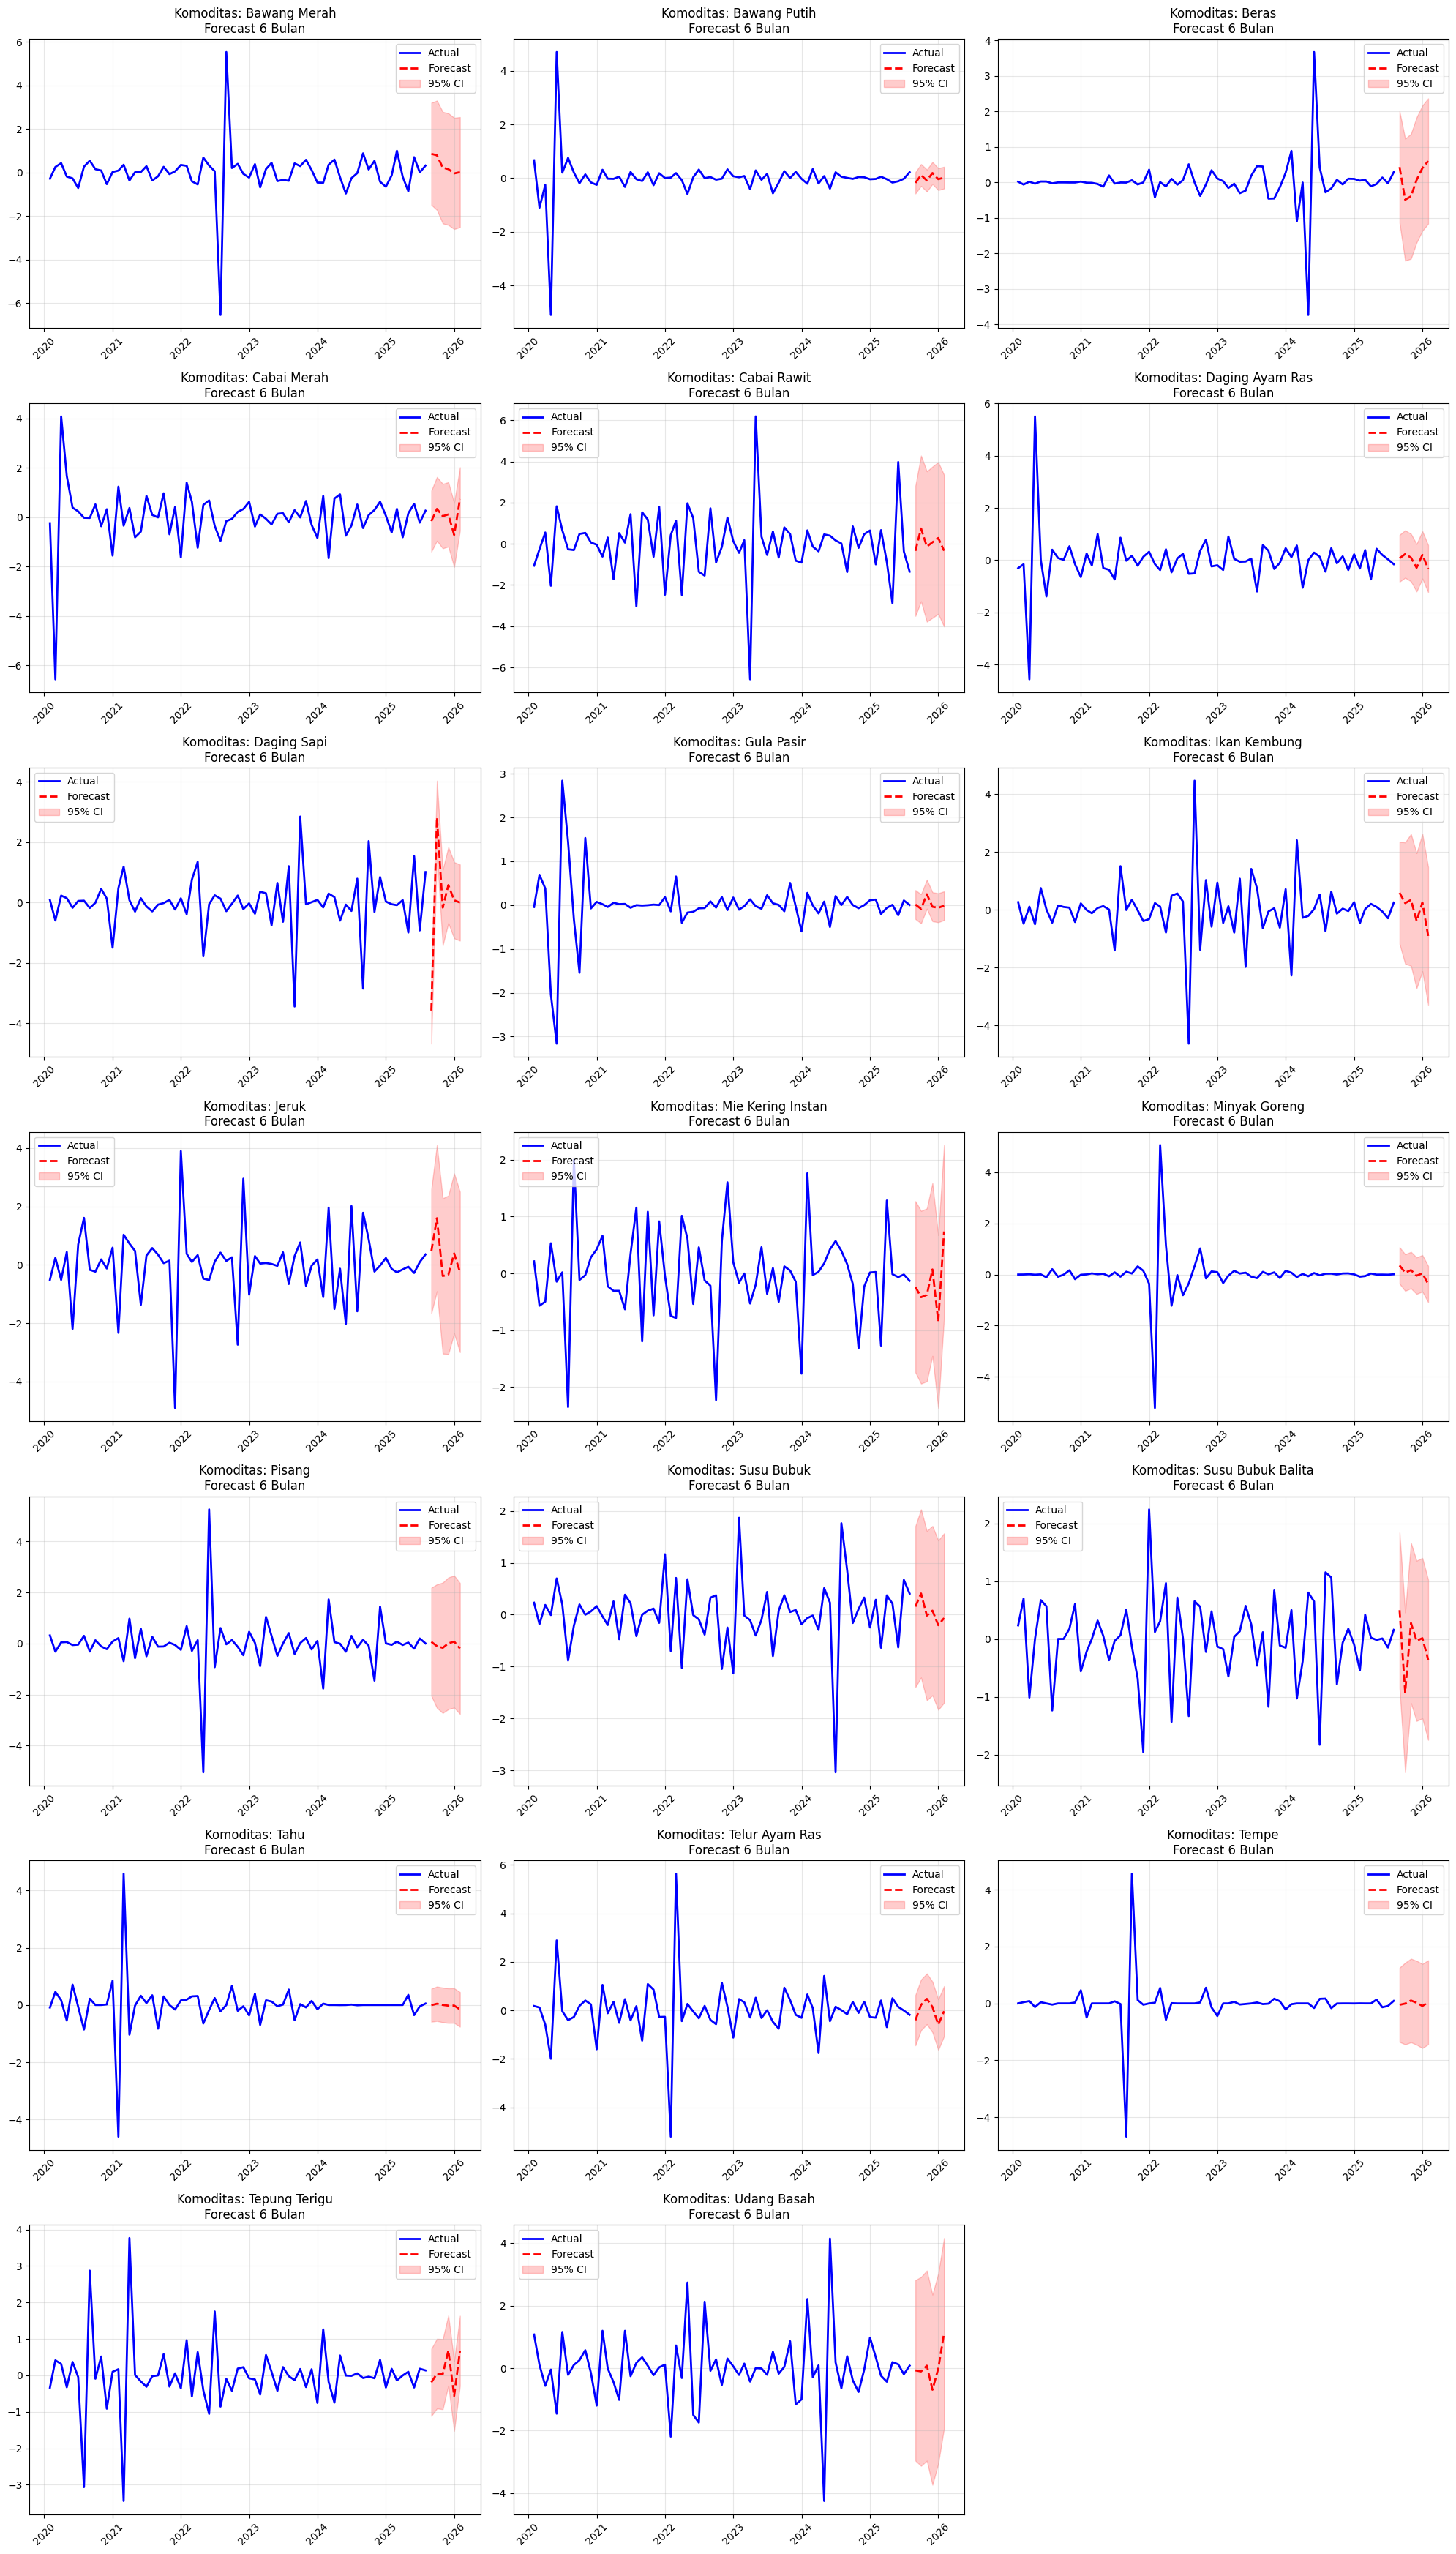

Generating 3 inflation plot(s)...
✅ Plot inflasi disimpan sebagai 'forecast_inflation.png'


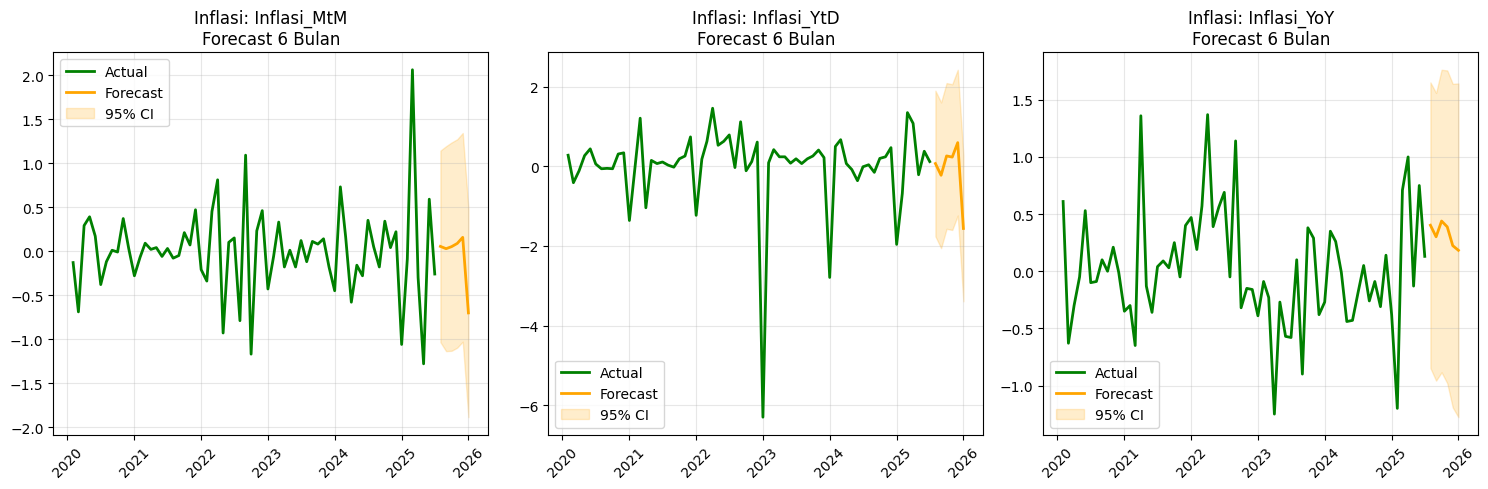


=== EXPORTING TO CSV ===
✅ Hasil forecast disimpan sebagai 'forecast_results.csv'
   Total baris: 138
   Komoditas: 20
   Inflasi: 3

=== EXPORTING EVALUATION RESULTS ===
✅ Hasil evaluasi disimpan sebagai 'evaluation_results.csv'
✅ Summary statistics disimpan sebagai 'evaluation_summary_stats.csv'

=== PREVIEW HASIL FORECAST ===
       Jenis         Nama    Bulan    Tanggal  Forecast  Lower_CI  Upper_CI
120  Inflasi  Inflasi_MtM  2025-08 2025-08-01    0.0538   -1.0340    1.1415
121  Inflasi  Inflasi_MtM  2025-09 2025-09-01    0.0277   -1.1361    1.1915
122  Inflasi  Inflasi_MtM  2025-10 2025-10-01    0.0509   -1.1321    1.2340
123  Inflasi  Inflasi_MtM  2025-11 2025-11-01    0.0874   -1.0963    1.2710
124  Inflasi  Inflasi_MtM  2025-12 2025-12-01    0.1566   -1.0285    1.3416
125  Inflasi  Inflasi_MtM  2026-01 2026-01-01   -0.7017   -1.8860    0.4826
132  Inflasi  Inflasi_YoY  2025-08 2025-08-01    0.4024   -0.8473    1.6520
133  Inflasi  Inflasi_YoY  2025-09 2025-09-01    0.3012   -0

In [32]:
# Cell BARU — Jalankan Semua Forecasting
# ====== RUN ALL FORECASTING ======

print("=== MENJALANKAN FORECASTING UTAMA ===")
forecasts, model_results = run_forecasting_pipeline(
    series_map, 
    horizon=FORECAST_HORIZON,
    use_grid_search=USE_GRID_SEARCH,
    exog_policy=EXOG_POLICY
)

print(f"\n✅ Forecasting komoditas selesai: {len(forecasts)} komoditas berhasil")

print("\n=== MENJALANKAN FORECASTING INFLASI ===")
inflation_forecasts, inflation_model_results = run_inflation_forecasting(
    inflasi_series,
    horizon=FORECAST_HORIZON,
    use_grid_search=USE_GRID_SEARCH
)

print(f"✅ Forecasting inflasi selesai: {len(inflation_forecasts)} series inflasi berhasil")

# Jalankan evaluasi train-test (jika diperlukan)
print("\n=== MENJALANKAN EVALUASI TRAIN-TEST ===")
eval_results, summary_df, overall_stats_df = run_comprehensive_evaluation(
    forecasts, model_results, test_size=TEST_SIZE, horizon=FORECAST_HORIZON
)

# Jalankan visualisasi dan export
print("\n=== GENERATING VISUALIZATION ===")
plot_forecast_results(forecasts, inflation_forecasts)

print("\n=== EXPORTING TO CSV ===")
forecast_csv = export_to_csv(forecasts, inflation_forecasts)

# Export evaluation results secara terpisah jika ada
if eval_results and summary_df is not None:
    print("\n=== EXPORTING EVALUATION RESULTS ===")
    eval_csv, stats_csv = export_evaluation_results(eval_results, summary_df, overall_stats_df)

# Tampilkan preview hasil
if forecast_csv is not None:
    print("\n=== PREVIEW HASIL FORECAST ===")
    print(forecast_csv.head(10))
    
    # Tampilkan summary
    print("\n=== SUMMARY FORECAST ===")
    print(f"Total forecast: {len(forecast_csv)} baris")
    print(f"Komoditas: {forecast_csv[forecast_csv['Jenis'] == 'Komoditas']['Nama'].nunique()} jenis")
    print(f"Inflasi: {forecast_csv[forecast_csv['Jenis'] == 'Inflasi']['Nama'].nunique()} jenis")


=== ANALISIS PERFORMA MODEL ===

ANALISIS PERFORMA MODEL

1. PENGARUH PENGGUNAAN EKSOGEN:
                MAPE         Komoditas
                mean     std     count
Exog_Used                             
3             6.9328  5.9555         4
4            18.3636 18.7200        15
5         1,943.0470     NaN         1

2. DISTRIBUSI METRIK MAPE:
MAPE (%):
   Mean: 112.3116
   Std:  431.2416
   Min:  1.0334
   Max:  1943.0470
   Q1:   4.2710
   Q3:   25.6650

3. KATEGORI PERFORMA BERDASARKAN MAPE:
   Excellent (MAPE < mean - std): 0 model
   Good (mean - std ≤ MAPE < mean): 19 model
   Fair (mean ≤ MAPE < mean + std): 0 model
   Poor (MAPE ≥ mean + std): 1 model

4. INTERPRETASI NILAI MAPE:
   Sangat Baik (MAPE < 10%): 9 model
   Baik (10% ≤ MAPE < 20%): 5 model
   Cukup (20% ≤ MAPE < 50%): 4 model
   Buruk (MAPE ≥ 50%): 2 model

=== PLOTTING DISTRIBUSI PERFORMA ===


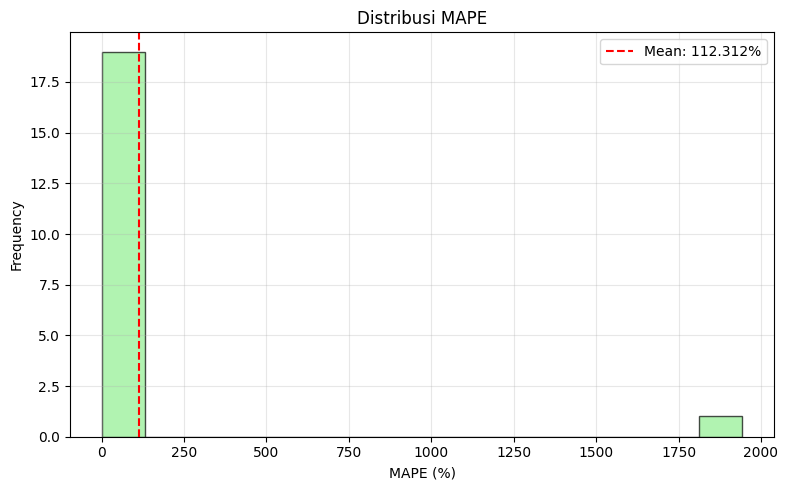


=== PLOTTING PERBANDINGAN MAPE ===


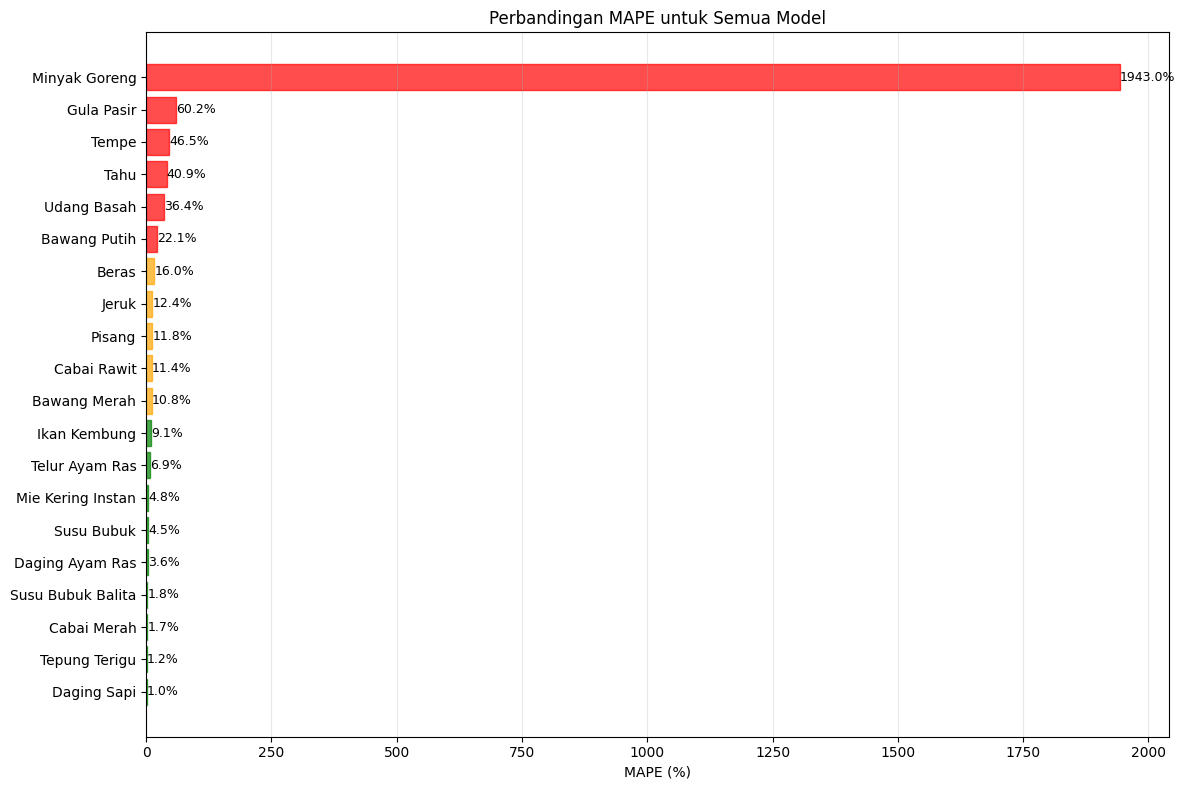

In [33]:
# Cell 3 — Model Comparison & Analysis
# ====== MODEL COMPARISON & ANALYSIS ======

def analyze_model_performance(summary_df):
    """Analisis performa model secara mendalam - HANYA MAPE"""
    
    if summary_df is None:
        print("❌ Tidak ada data untuk dianalisis")
        return
    
    print("\n" + "="*50)
    print("ANALISIS PERFORMA MODEL")
    print("="*50)
    
    # Analisis berdasarkan penggunaan eksogen
    if 'Exog_Used' in summary_df.columns:
        print("\n1. PENGARUH PENGGUNAAN EKSOGEN:")
        exog_stats = summary_df.groupby('Exog_Used').agg({
            'MAPE': ['mean', 'std'],
            'Komoditas': 'count'
        }).round(4)
        print(exog_stats)
    
    # Analisis berdasarkan model complexity
    print("\n2. DISTRIBUSI METRIK MAPE:")
    if 'MAPE' in summary_df.columns:
        data = summary_df['MAPE']
        print(f"MAPE (%):")
        print(f"   Mean: {data.mean():.4f}")
        print(f"   Std:  {data.std():.4f}")
        print(f"   Min:  {data.min():.4f}")
        print(f"   Max:  {data.max():.4f}")
        print(f"   Q1:   {data.quantile(0.25):.4f}")
        print(f"   Q3:   {data.quantile(0.75):.4f}")
    
    # Kategori performa berdasarkan MAPE
    print("\n3. KATEGORI PERFORMA BERDASARKAN MAPE:")
    if 'MAPE' in summary_df.columns:
        mape_mean = summary_df['MAPE'].mean()
        mape_std = summary_df['MAPE'].std()
        
        excellent_mape = summary_df[summary_df['MAPE'] < mape_mean - mape_std]
        good_mape = summary_df[(summary_df['MAPE'] >= mape_mean - mape_std) & (summary_df['MAPE'] < mape_mean)]
        fair_mape = summary_df[(summary_df['MAPE'] >= mape_mean) & (summary_df['MAPE'] < mape_mean + mape_std)]
        poor_mape = summary_df[summary_df['MAPE'] >= mape_mean + mape_std]
        
        print(f"   Excellent (MAPE < mean - std): {len(excellent_mape)} model")
        print(f"   Good (mean - std ≤ MAPE < mean): {len(good_mape)} model")
        print(f"   Fair (mean ≤ MAPE < mean + std): {len(fair_mape)} model")
        print(f"   Poor (MAPE ≥ mean + std): {len(poor_mape)} model")
        
        # Interpretasi nilai MAPE
        print("\n4. INTERPRETASI NILAI MAPE:")
        excellent_int = summary_df[summary_df['MAPE'] < 10]
        good_int = summary_df[(summary_df['MAPE'] >= 10) & (summary_df['MAPE'] < 20)]
        fair_int = summary_df[(summary_df['MAPE'] >= 20) & (summary_df['MAPE'] < 50)]
        poor_int = summary_df[summary_df['MAPE'] >= 50]
        
        print(f"   Sangat Baik (MAPE < 10%): {len(excellent_int)} model")
        print(f"   Baik (10% ≤ MAPE < 20%): {len(good_int)} model")
        print(f"   Cukup (20% ≤ MAPE < 50%): {len(fair_int)} model")
        print(f"   Buruk (MAPE ≥ 50%): {len(poor_int)} model")

def plot_performance_distribution(summary_df):
    """Plot distribusi performa model - HANYA MAPE"""
    
    if summary_df is None:
        return
    
    fig, ax = plt.subplots(1, 1, figsize=(8, 5))
    
    # HANYA 1 METRIC YANG DIPLOT: MAPE
    if 'MAPE' in summary_df.columns:
        ax.hist(summary_df['MAPE'], bins=15, alpha=0.7, color='lightgreen', edgecolor='black')
        ax.axvline(summary_df['MAPE'].mean(), color='red', linestyle='--', 
                  label=f'Mean: {summary_df["MAPE"].mean():.3f}%')
        ax.set_title('Distribusi MAPE')
        ax.set_xlabel('MAPE (%)')
        ax.set_ylabel('Frequency')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('performance_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_mape_comparison(summary_df):
    """Plot perbandingan MAPE untuk semua model"""
    
    if summary_df is None:
        return
    
    # Urutkan berdasarkan MAPE
    sorted_df = summary_df.sort_values('MAPE', ascending=True)
    
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Plot horizontal bars
    y_pos = np.arange(len(sorted_df))
    bars = ax.barh(y_pos, sorted_df['MAPE'], color='skyblue', alpha=0.7)
    
    # Warna berdasarkan performa
    for i, bar in enumerate(bars):
        mape_val = sorted_df['MAPE'].iloc[i]
        if mape_val < 10:
            bar.set_color('green')
        elif mape_val < 20:
            bar.set_color('orange')
        else:
            bar.set_color('red')
    
    ax.set_yticks(y_pos)
    ax.set_yticklabels(sorted_df['Komoditas'])
    ax.set_xlabel('MAPE (%)')
    ax.set_title('Perbandingan MAPE untuk Semua Model')
    ax.grid(True, alpha=0.3, axis='x')
    
    # Tambah nilai di ujung bar
    for i, v in enumerate(sorted_df['MAPE']):
        ax.text(v + 0.5, i, f'{v:.1f}%', va='center', fontsize=9)
    
    plt.tight_layout()
    plt.savefig('mape_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

# Jalankan analisis
if summary_df is not None:
    print("\n=== ANALISIS PERFORMA MODEL ===")
    analyze_model_performance(summary_df)
    
    print("\n=== PLOTTING DISTRIBUSI PERFORMA ===")
    plot_performance_distribution(summary_df)
    
    print("\n=== PLOTTING PERBANDINGAN MAPE ===")
    plot_mape_comparison(summary_df)